# Part 1a) Importing Time Series for Flow, Precip, and Temp
# b) Creating single dataframes with pandas
# c) Converting to proper datetime formate with to_timestamp()

In [1]:
############################## this data is from ulmo############################
import ulmo
import pandas as pd

mangoflow_u = ulmo.usgs.nwis.get_site_data(site_code='50055750', start='01/01/2000', end='12/30/2016')
valencianoflow_u = ulmo.usgs.nwis.get_site_data(site_code='50056400', start='01/01/2000', end='12/30/2016')
loizaflow_u = ulmo.usgs.nwis.get_site_data(site_code='50050900', start='01/01/2000', end='12/30/2016')

mango_values_dict = mangoflow_u['00060:00003']['values']
valenciano_values_dict = valencianoflow_u['00060:00003']['values']
loiza_values_dict = loizaflow_u['00060:00003']['values']


mangoDF = pd.DataFrame(mango_values_dict)
mangoDF['name'] = mangoflow_u['00060:00003']['site']['name']
valencianoDF = pd.DataFrame(valenciano_values_dict)
valencianoDF['name'] = valencianoflow_u['00060:00003']['site']['name']
loizaDF = pd.DataFrame(loiza_values_dict)
loizaDF['name'] = loizaflow_u['00060:00003']['site']['name']


flowDFlist = [mangoDF, valencianoDF, loizaDF]

allflow = pd.concat(flowDFlist)
allflow['value'] = [float(thisValue) for thisValue in allflow['value']]

with pd.HDFStore('data/flow.h5', mode='w') as flowhdf:
    flowhdf.put('d1', allflow, format='table', data_columns=True)
    # head doesn't just print out the first five for some reason

/home/anaconda3/lib/python3.6/site-packages/ulmo/twc/kbdi/core.py:20: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  CSV_SWITCHOVER = pandas.tslib.Timestamp('2016-10-01')
/home/anaconda3/lib/python3.6/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
/home/anaconda3/lib/python3.6/site-packages/ulmo/usgs/nwis/core.py:255: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  end_datetime = util.convert_datetime(end)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=50055750&startDT=2000-01-01&endDT=2016-12-30
processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml&site=50055750&startDT=2000-01-01T00%3A00%3A00&endDT=2016-12-30T00%3A00%3A00
processing data from request: https://waterservices.usgs.gov/nwis/dv/?forma

In [2]:
import pandas as pd
with pd.HDFStore('data/flow.h5',  mode='r') as newstore:
    flowdf = newstore.select('d1')
flowdf.head

<bound method NDFrame.head of                  datetime qualifiers  value  \
0     2000-01-01T00:00:00          A   27.0   
1     2000-01-02T00:00:00          A   21.0   
2     2000-01-03T00:00:00          A   76.0   
3     2000-01-04T00:00:00          A   64.0   
4     2000-01-05T00:00:00          A   98.0   
5     2000-01-06T00:00:00          A   73.0   
6     2000-01-07T00:00:00          A  100.0   
7     2000-01-08T00:00:00          A   32.0   
8     2000-01-09T00:00:00          A   26.0   
9     2000-01-10T00:00:00          A   20.0   
10    2000-01-11T00:00:00          A   18.0   
11    2000-01-12T00:00:00          A   17.0   
12    2000-01-13T00:00:00          A   16.0   
13    2000-01-14T00:00:00          A   17.0   
14    2000-01-15T00:00:00          A   17.0   
15    2000-01-16T00:00:00          A   87.0   
16    2000-01-17T00:00:00          A   20.0   
17    2000-01-18T00:00:00          A   16.0   
18    2000-01-19T00:00:00          A   15.0   
19    2000-01-20T00:00:00     

In [3]:
# now get noaa ncdc temp and precip

ponce_ncdc = ulmo.ncdc.ghcn_daily.get_data('RQC00667292', as_dataframe=True)
piedras_ncdc = ulmo.ncdc.ghcn_daily.get_data('RQC00668306', as_dataframe=True)
roosevelt_ncdc = ulmo.ncdc.ghcn_daily.get_data('RQW00011630', as_dataframe=True)

def getallvar(d1,d2,d3, measure, startdate, enddate):
    
    listd = [d2, d3]
    listnames = ['Ponce', 'Piedras', 'Roosevelt Roads']
    tmin = d1[measure]
    tmin['value'] = [float(thisValue)/10 for thisValue in tmin['value']]
    tmin['name'] = listnames[0]
    tmin = tmin[startdate:enddate]
    index = 1
    for d in listd:
        tmintoadd = d[measure]
        tmintoadd['value'] = [float(thisValue)/10 for thisValue in tmintoadd['value']]
        tmintoadd['name'] = listnames[index]
        tmintoadd = tmintoadd[startdate:enddate]
        tmin = pd.concat([tmin,tmintoadd])
        index += 1
    #converts to datetime    
    tmin.index = tmin.index.to_timestamp()
    tmin = tmin.reset_index()
    return tmin

alltmin = getallvar(ponce_ncdc, piedras_ncdc, roosevelt_ncdc,'TMIN','2000-01-01','2016-12-30')
with pd.HDFStore('data/tmin.h5', mode='w') as tminhdf:
    tminhdf.put('d1', alltmin, format='table', data_columns=True)

allprecip = getallvar(ponce_ncdc, piedras_ncdc, roosevelt_ncdc,'PRCP', '2000-01-01','2016-12-30' )
allprecip['value'] = [float(thisValue)*10 for thisValue in allprecip['value']]
with pd.HDFStore('data/precip.h5', mode='w') as preciphdf:
    preciphdf.put('d1', allprecip, format='table', data_columns=True)


/home/anaconda3/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/home/anaconda3/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/home/anaconda3/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[

In [3]:
with pd.HDFStore('data/tmin.h5',  mode='r') as newtmin:
    tmindf = newtmin.select('d1')
# tmindf.drop(axis=1,columns=['mflag', 'qflag', 'sflag']) this errors, couldn't debug

In [4]:
with pd.HDFStore('data/precip.h5',  mode='r') as newprecip:
    precipdf = newprecip.select('d1')
precipdf.head

<bound method NDFrame.head of       month_period  value mflag qflag sflag             name
0       2000-01-01   30.0   NaN   NaN     0            Ponce
1       2000-01-02    0.0   NaN   NaN     0            Ponce
2       2000-01-03    0.0   NaN   NaN     0            Ponce
3       2000-01-04    0.0   NaN   NaN     0            Ponce
4       2000-01-05   13.0   NaN   NaN     0            Ponce
5       2000-01-06    0.0   NaN   NaN     0            Ponce
6       2000-01-07    0.0   NaN   NaN     0            Ponce
7       2000-01-08    0.0   NaN   NaN     0            Ponce
8       2000-01-09    0.0   NaN   NaN     0            Ponce
9       2000-01-10    0.0   NaN   NaN     0            Ponce
10      2000-01-11    0.0   NaN   NaN     0            Ponce
11      2000-01-12    0.0   NaN   NaN     0            Ponce
12      2000-01-13    0.0   NaN   NaN     0            Ponce
13      2000-01-14    0.0   NaN   NaN     0            Ponce
14      2000-01-15    0.0   NaN   NaN     0            

## Part 1d) Sorting by datetime

In [51]:
flowdf.columns

Index(['datetime', 'qualifiers', 'value', 'name'], dtype='object')

In [5]:
flowdf.sort_values('datetime', ascending=True)
tmindf.sort_values('month_period', ascending=True)
precipdf.sort_values('month_period', ascending=True)

month_period  value mflag qflag sflag             name
0       2000-01-01   30.0   NaN   NaN     0            Ponce
12418   2000-01-01    NaN   NaN   NaN   NaN  Roosevelt Roads
6209    2000-01-01    NaN   NaN   NaN   NaN          Piedras
1       2000-01-02    0.0   NaN   NaN     0            Ponce
12419   2000-01-02    NaN   NaN   NaN   NaN  Roosevelt Roads
6210    2000-01-02    NaN   NaN   NaN   NaN          Piedras
2       2000-01-03    0.0   NaN   NaN     0            Ponce
12420   2000-01-03    NaN   NaN   NaN   NaN  Roosevelt Roads
6211    2000-01-03    NaN   NaN   NaN   NaN          Piedras
3       2000-01-04    0.0   NaN   NaN     0            Ponce
12421   2000-01-04    NaN   NaN   NaN   NaN  Roosevelt Roads
6212    2000-01-04    NaN   NaN   NaN   NaN          Piedras
12422   2000-01-05    NaN   NaN   NaN   NaN  Roosevelt Roads
6213    2000-01-05    NaN   NaN   NaN   NaN          Piedras
4       2000-01-05   13.0   NaN   NaN     0            Ponce
6214    2000-01-06    NaN   NaN   NaN   NaN          Piedras
5       2000-01-06    0.0   NaN   NaN     0            Ponce
12423   2000-01-06    NaN   NaN   NaN   NaN  Roosevelt Roads
6215    2000-01-07    NaN   NaN   NaN   NaN          Piedras
6       2000-01-07    0.0   NaN   NaN     0            Ponce
12424   2000-01-07    NaN   NaN   NaN   NaN  Roosevelt Roads
6216    2000-01-08    NaN   NaN   NaN   NaN          Piedras
12425   2000-01-08    NaN   NaN   NaN   NaN  Roosevelt Roads
7       2000-01-08    0.0   NaN   NaN     0            Ponce
12426   2000-01-09    NaN   NaN   NaN   NaN  Roosevelt Roads
6217    2000-01-09    NaN   NaN   NaN   NaN          Piedras
8       2000-01-09    0.0   NaN   NaN     0            Ponce
12427   2000-01-10    NaN   NaN   NaN   NaN  Roosevelt Roads
6218    2000-01-10    NaN   NaN   NaN   NaN          Piedras
9       2000-01-10    0.0   NaN   NaN     0            Ponce
...            ...    ...   ...   ...   ...              ...
6199    2016-12-21    0.0   NaN   NaN     7            Ponce
18617   2016-12-21    0.0   NaN   NaN     W  Roosevelt Roads
12408   2016-12-21    NaN   NaN   NaN   NaN          Piedras
6200    2016-12-22   10.0   NaN   NaN     7            Ponce
18618   2016-12-22    0.0     T   NaN     W  Roosevelt Roads
12409   2016-12-22    NaN   NaN   NaN   NaN          Piedras
12410   2016-12-23    NaN   NaN   NaN   NaN          Piedras
6201    2016-12-23    0.0   NaN   NaN     7            Ponce
18619   2016-12-23   10.0   NaN   NaN     W  Roosevelt Roads
12411   2016-12-24    NaN   NaN   NaN   NaN          Piedras
6202    2016-12-24    NaN   NaN   NaN   NaN            Ponce
18620   2016-12-24   33.0   NaN   NaN     W  Roosevelt Roads
18621   2016-12-25    8.0   NaN   NaN     W  Roosevelt Roads
6203    2016-12-25    NaN   NaN   NaN   NaN            Ponce
12412   2016-12-25    NaN   NaN   NaN   NaN          Piedras
12413   2016-12-26    NaN   NaN   NaN   NaN          Piedras
18622   2016-12-26    5.0   NaN   NaN     W  Roosevelt Roads
6204    2016-12-26    NaN   NaN   NaN   NaN            Ponce
12414   2016-12-27    NaN   NaN   NaN   NaN          Piedras
18623   2016-12-27   53.0   NaN   NaN     W  Roosevelt Roads
6205    2016-12-27    NaN   NaN   NaN   NaN            Ponce
12415   2016-12-28    NaN   NaN   NaN   NaN          Piedras
18624   2016-12-28    0.0   NaN   NaN     W  Roosevelt Roads
6206    2016-12-28    NaN   NaN   NaN   NaN            Ponce
18625   2016-12-29    0.0     T   NaN     W  Roosevelt Roads
6207    2016-12-29    NaN   NaN   NaN   NaN            Ponce
12416   2016-12-29    NaN   NaN   NaN   NaN          Piedras
12417   2016-12-30    NaN   NaN   NaN   NaN          Piedras
6208    2016-12-30    NaN   NaN   NaN   NaN            Ponce
18626   2016-12-30    0.0   NaN   NaN     W  Roosevelt Roads

[18627 rows x 6 columns]

## 2) Resampling Time Series Data with Split-Apply-Combine

In [6]:
flowdf['datetime'] = [pd.to_datetime(thisDate) for thisDate in flowdf['datetime']]
flowdf['year'] = [thisDate.year for thisDate in flowdf['datetime']]
precipdf['year'] = [thisDate.year for thisDate in precipdf['month_period']]
tmindf['year'] = [thisDate.year for thisDate in tmindf['month_period']]

In [7]:
flowdf['month'] = [thisDate.month for thisDate in flowdf['datetime']]
precipdf['month'] = [thisDate.month for thisDate in precipdf['month_period']]
tmindf['month'] = [thisDate.month for thisDate in tmindf['month_period']]

In [8]:
flowdf['day'] = [thisDate.dayofyear for thisDate in flowdf['datetime']]
precipdf['day'] = [thisDate.dayofyear for thisDate in precipdf['month_period']]
tmindf['day'] = [thisDate.dayofyear for thisDate in tmindf['month_period']]

In [10]:
print(flowdf)

       datetime qualifiers  value                                        name  \
0    2000-01-01          A   27.0                 RIO GURABO BLW EL MANGO, PR   
1    2000-01-02          A   21.0                 RIO GURABO BLW EL MANGO, PR   
2    2000-01-03          A   76.0                 RIO GURABO BLW EL MANGO, PR   
3    2000-01-04          A   64.0                 RIO GURABO BLW EL MANGO, PR   
4    2000-01-05          A   98.0                 RIO GURABO BLW EL MANGO, PR   
5    2000-01-06          A   73.0                 RIO GURABO BLW EL MANGO, PR   
6    2000-01-07          A  100.0                 RIO GURABO BLW EL MANGO, PR   
7    2000-01-08          A   32.0                 RIO GURABO BLW EL MANGO, PR   
8    2000-01-09          A   26.0                 RIO GURABO BLW EL MANGO, PR   
9    2000-01-10          A   20.0                 RIO GURABO BLW EL MANGO, PR   
10   2000-01-11          A   18.0                 RIO GURABO BLW EL MANGO, PR   
11   2000-01-12          A  

In [11]:
print(precipdf)

      month_period  value mflag qflag sflag             name  year  month  day
0       2000-01-01   30.0   NaN   NaN     0            Ponce  2000      1    1
1       2000-01-02    0.0   NaN   NaN     0            Ponce  2000      1    2
2       2000-01-03    0.0   NaN   NaN     0            Ponce  2000      1    3
3       2000-01-04    0.0   NaN   NaN     0            Ponce  2000      1    4
4       2000-01-05   13.0   NaN   NaN     0            Ponce  2000      1    5
5       2000-01-06    0.0   NaN   NaN     0            Ponce  2000      1    6
6       2000-01-07    0.0   NaN   NaN     0            Ponce  2000      1    7
7       2000-01-08    0.0   NaN   NaN     0            Ponce  2000      1    8
8       2000-01-09    0.0   NaN   NaN     0            Ponce  2000      1    9
9       2000-01-10    0.0   NaN   NaN     0            Ponce  2000      1   10
10      2000-01-11    0.0   NaN   NaN     0            Ponce  2000      1   11
11      2000-01-12    0.0   NaN   NaN     0         

In [12]:
print(tmindf)

      month_period  value mflag qflag sflag             name  year  month  day
0       2000-01-01   18.3   NaN   NaN     0            Ponce  2000      1    1
1       2000-01-02   21.7   NaN   NaN     0            Ponce  2000      1    2
2       2000-01-03   21.1   NaN   NaN     0            Ponce  2000      1    3
3       2000-01-04   20.0   NaN   NaN     0            Ponce  2000      1    4
4       2000-01-05   18.3   NaN   NaN     0            Ponce  2000      1    5
5       2000-01-06   20.0   NaN   NaN     0            Ponce  2000      1    6
6       2000-01-07   19.4   NaN   NaN     0            Ponce  2000      1    7
7       2000-01-08   18.3   NaN   NaN     0            Ponce  2000      1    8
8       2000-01-09   18.9   NaN   NaN     0            Ponce  2000      1    9
9       2000-01-10   18.3   NaN   NaN     0            Ponce  2000      1   10
10      2000-01-11   17.8   NaN   NaN     0            Ponce  2000      1   11
11      2000-01-12   17.8   NaN   NaN     0         

## 2b) Calculate and Plot Long-Term Daily and Monthly Mean/Medians

In [9]:
flow_monthname_med = flowdf.groupby(['month', 'name']).median()
flow_dayname_med = flowdf.groupby(['day', 'name']).median()
flow_yearname_med = flowdf.groupby(['year','name']).median()

In [10]:
tmin_monthname_mean = tmindf.groupby(['month', 'name']).mean()
tmin_dayname_mean = tmindf.groupby(['day', 'name']).mean()
tmin_yearname_mean = tmindf.groupby(['year','name']).mean()

In [11]:
precip_monthname_mean = precipdf.groupby(['month', 'name']).mean()
precip_dayname_mean = precipdf.groupby(['day', 'name']).mean()
precip_yearname_mean = precipdf.groupby(['year','name']).mean()

In [12]:
import seaborn as sn
import matplotlib.pyplot as plt

def plotgroupsdays(df, ticklist, timestep='day', xtext='Day of Year', ytext='Median Stream Discharge in cubic feet per second', titletext='USGS Stream Gauge Data for 3 sites in Eastern PR Watershed, Grouped by Day, 2016'):
    sn.set(font_scale=6, rc={"lines.linewidth": 6})
    f = sn.FacetGrid(df.reset_index(), hue='name', size=40, aspect=2)
    f.map(plt.plot, timestep, 'value').add_legend()
    f.ax.set(xlabel=xtext,
            ylabel=ytext,
            title=titletext)
    f.fig.autofmt_xdate()
    f.set(yticks=ticklist)
    plt.show()
    
def plotgroupsmonths(df, ticklist, timestep='month', xtext='Month', ytext='Median Stream Discharge in cubic feet per second', titletext='USGS Stream Gauge Data for 3 sites in Eastern PR Watershed, Grouped by Month, 2016'):
    sn.set(font_scale=6, rc={"lines.linewidth": 6})
    f = sn.FacetGrid(df.reset_index(), hue='name', size=40, aspect=2)
    f.map(plt.plot, timestep, 'value').add_legend()
    f.ax.set(xlabel='Month',
            ylabel=ytext,
            title=titletext)
    f.fig.autofmt_xdate()
    f.set(yticks=ticklist)
    plt.show()
    
def plotgroupsyears(df, ticklist, timestep='year', ytext='Median Stream Discharge in cubic feet per second', titletext='USGS Stream Gauge Data for 3 sites in Eastern PR Watershed, Grouped by Year'):
    sn.set(font_scale=6, rc={"lines.linewidth": 6})
    f = sn.FacetGrid(df.reset_index(), hue='name', size=40, aspect=2)
    f.map(plt.plot, timestep, 'value').add_legend()
    f.ax.set(xlabel='Year',
            ylabel=ytext,
            title=titletext)
    f.fig.autofmt_xdate()
    f.set(yticks=ticklist)
    plt.show()

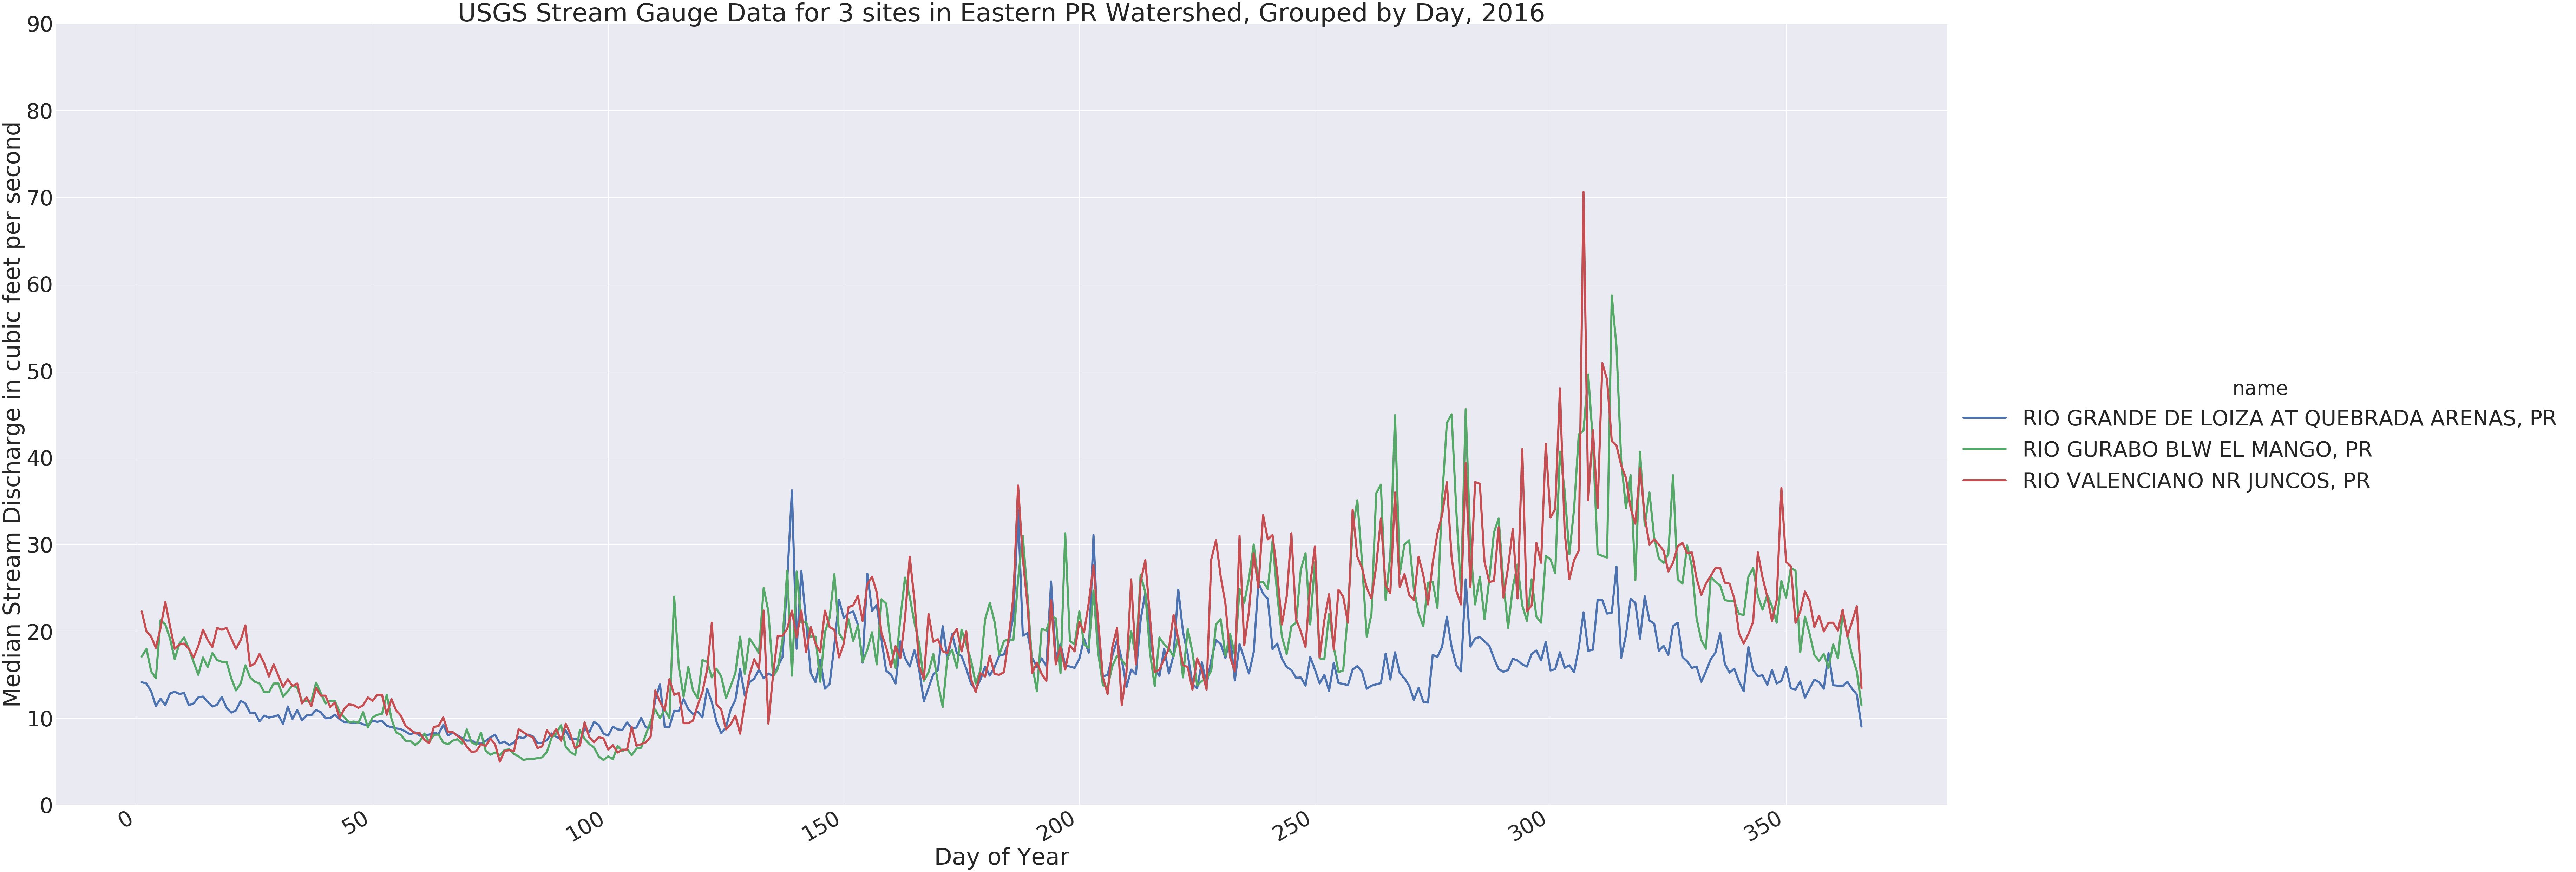

In [19]:
yticksdaysflow = list(range(0,100,10))
plotgroupsdays(flow_dayname_med, yticksdaysflow)


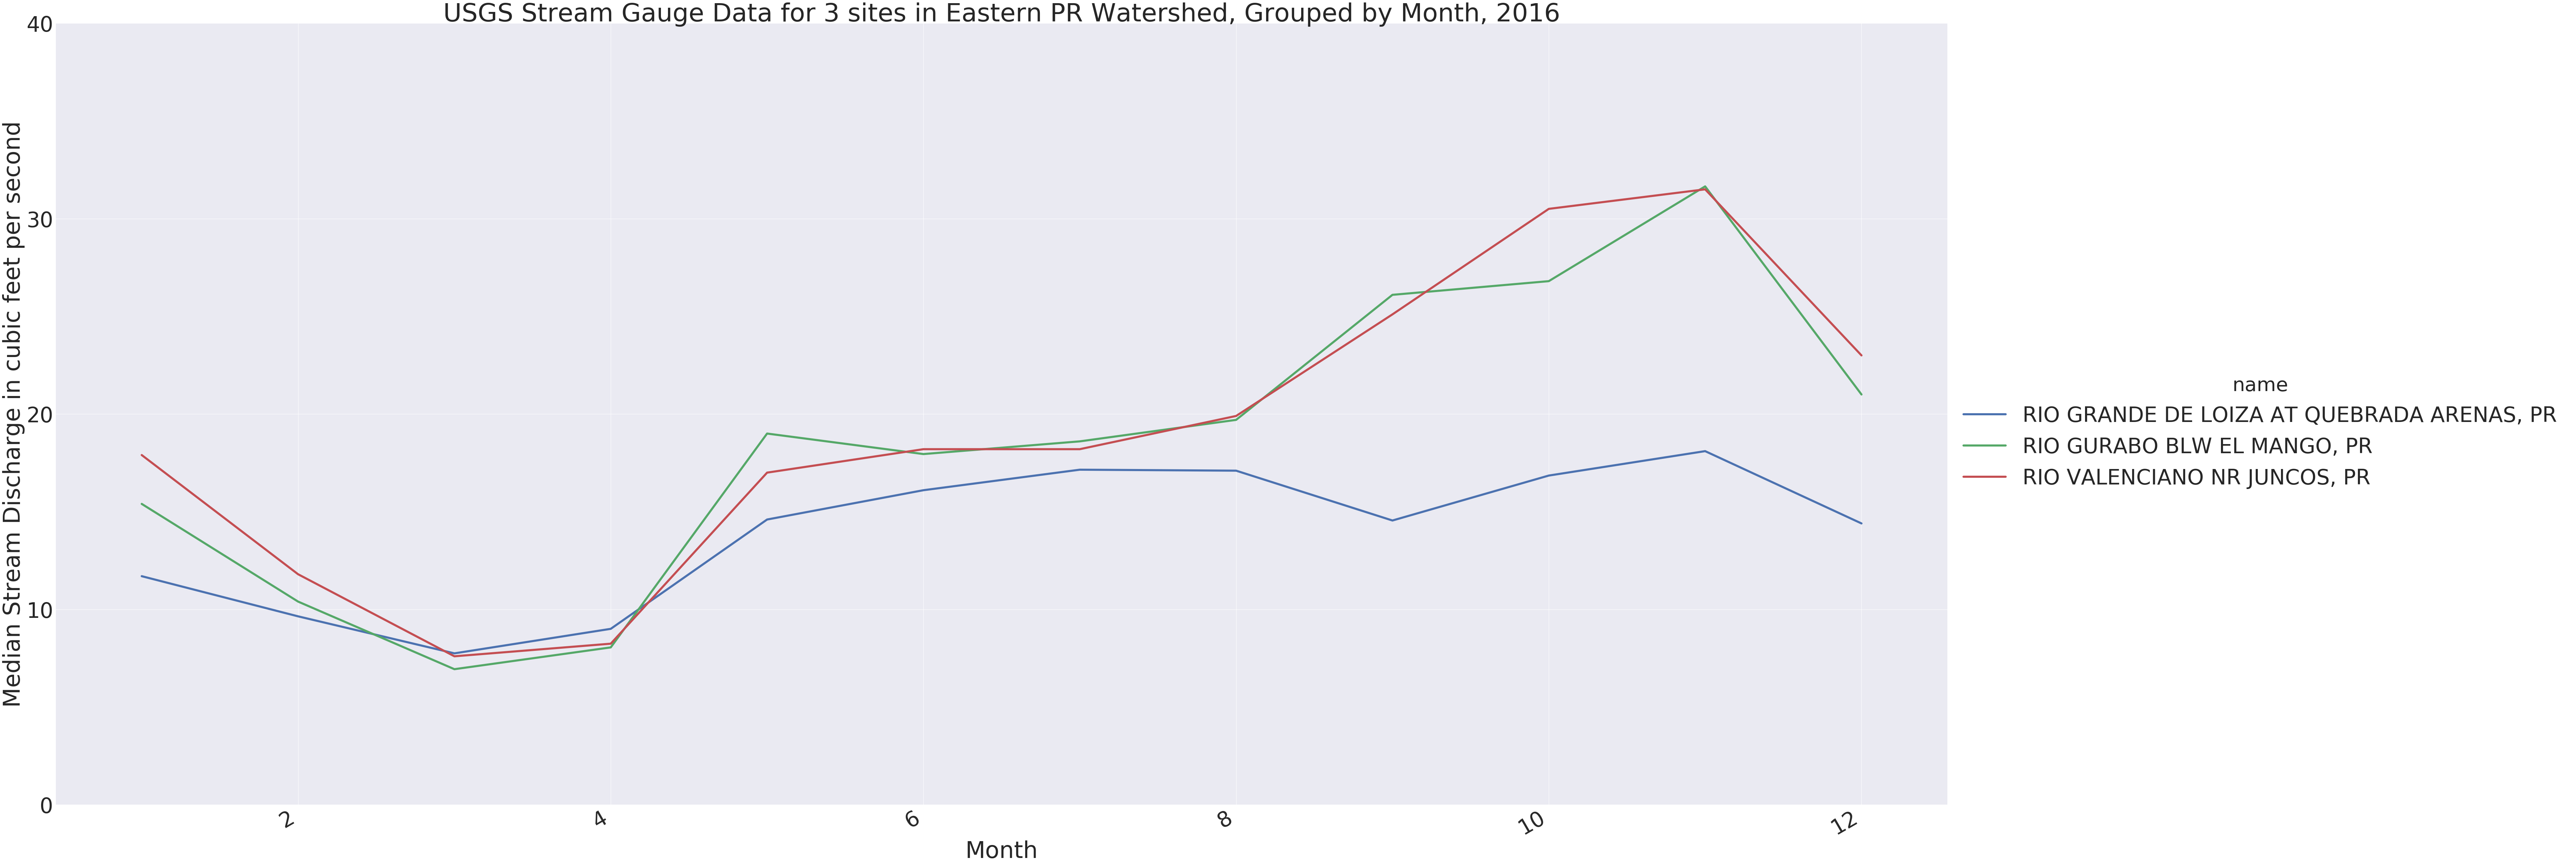

In [22]:
yticksmonthsflow = list(range(0,50,10))
plotgroupsmonths(flow_monthname_med, yticksmonthsflow)

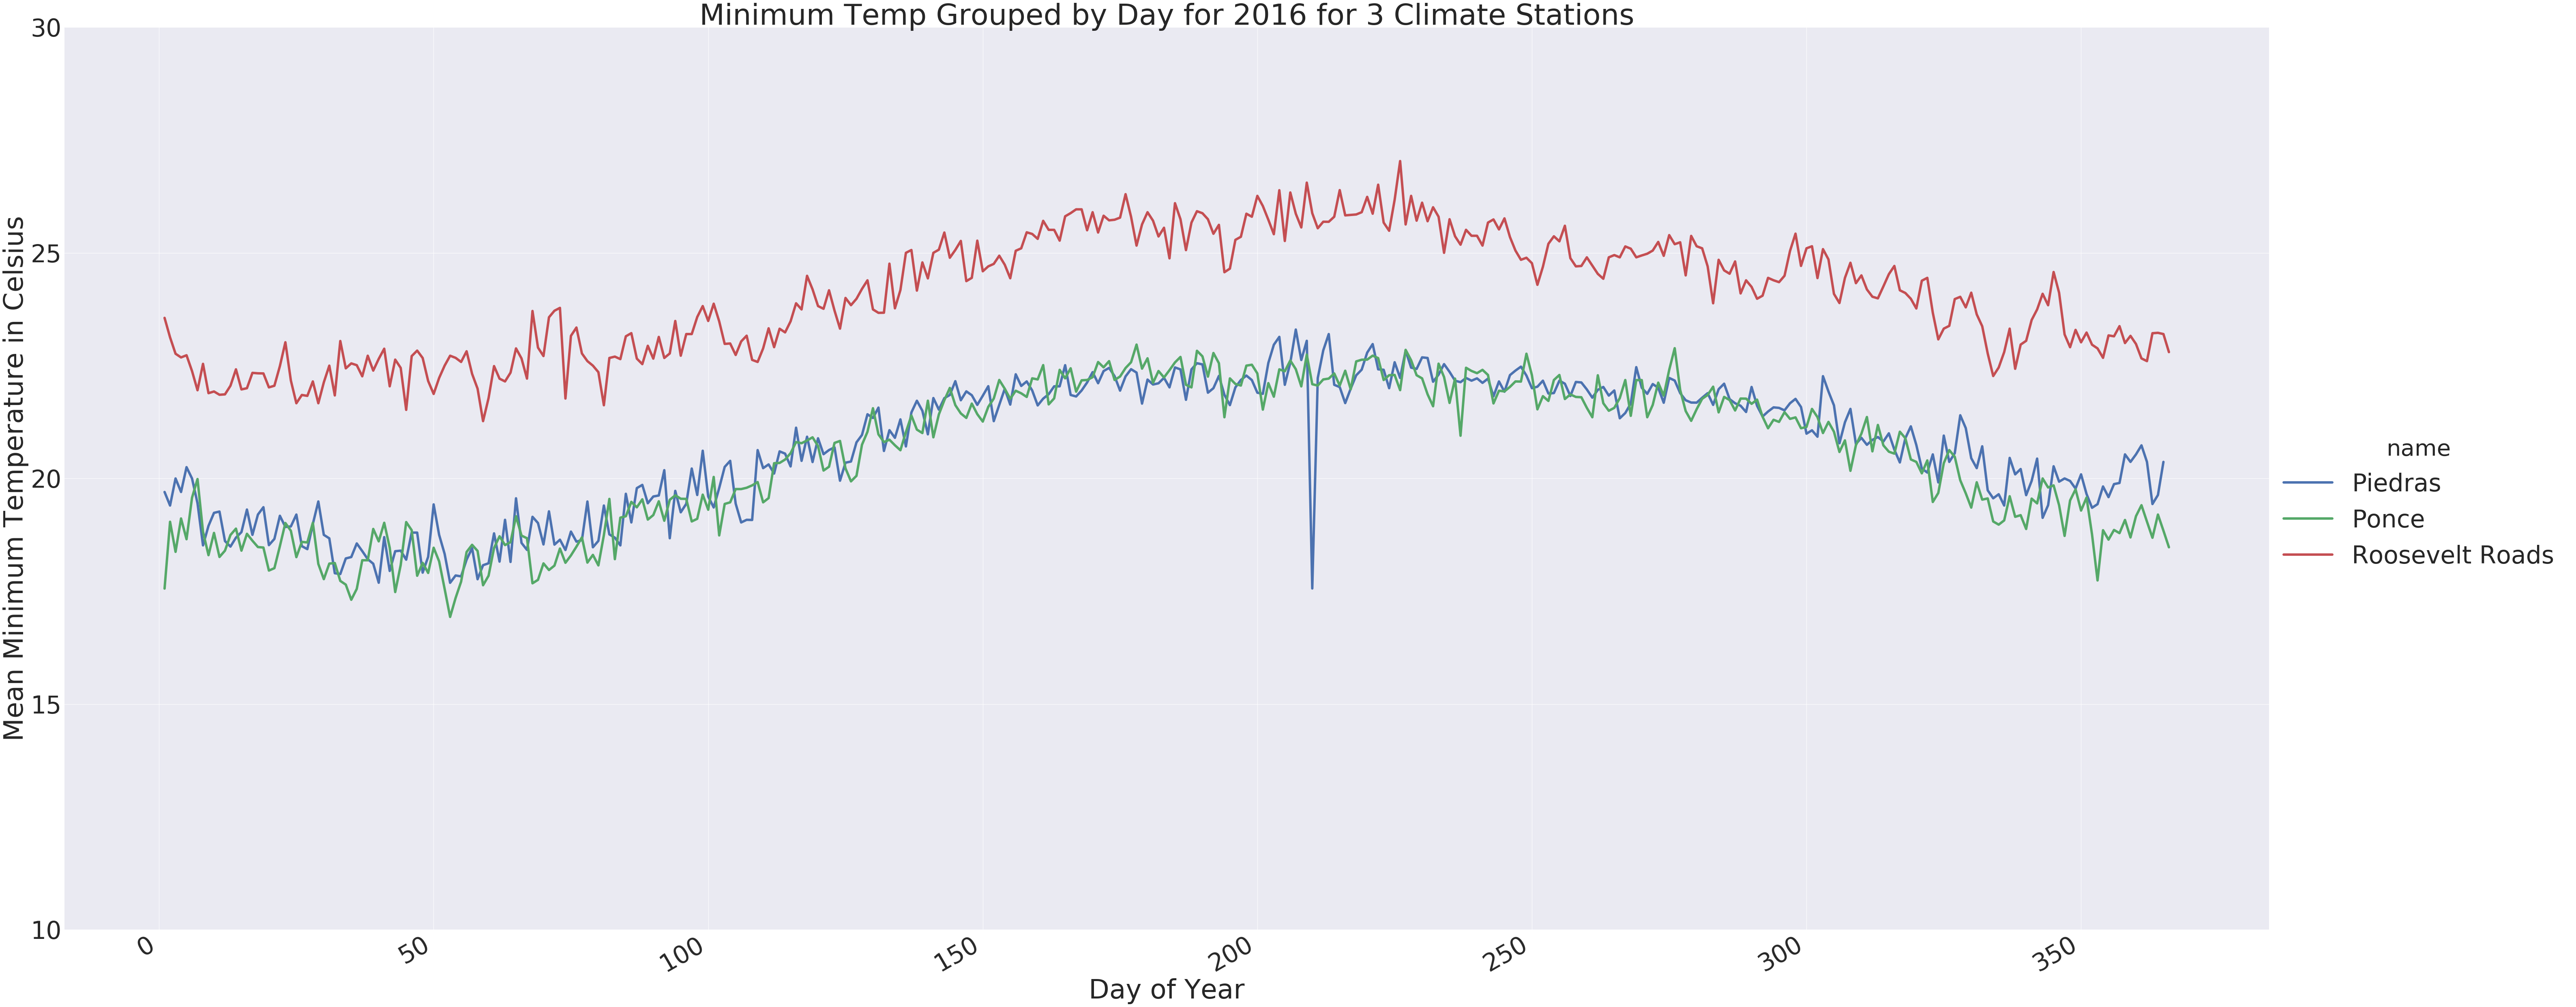

In [26]:
yticksdaystmin = list(range(10,35,5))
plotgroupsdays(tmin_dayname_mean, yticksdaystmin, ytext='Mean Minimum Temperature in Celsius',titletext='Minimum Temp Grouped by Day for 2016 for 3 Climate Stations')

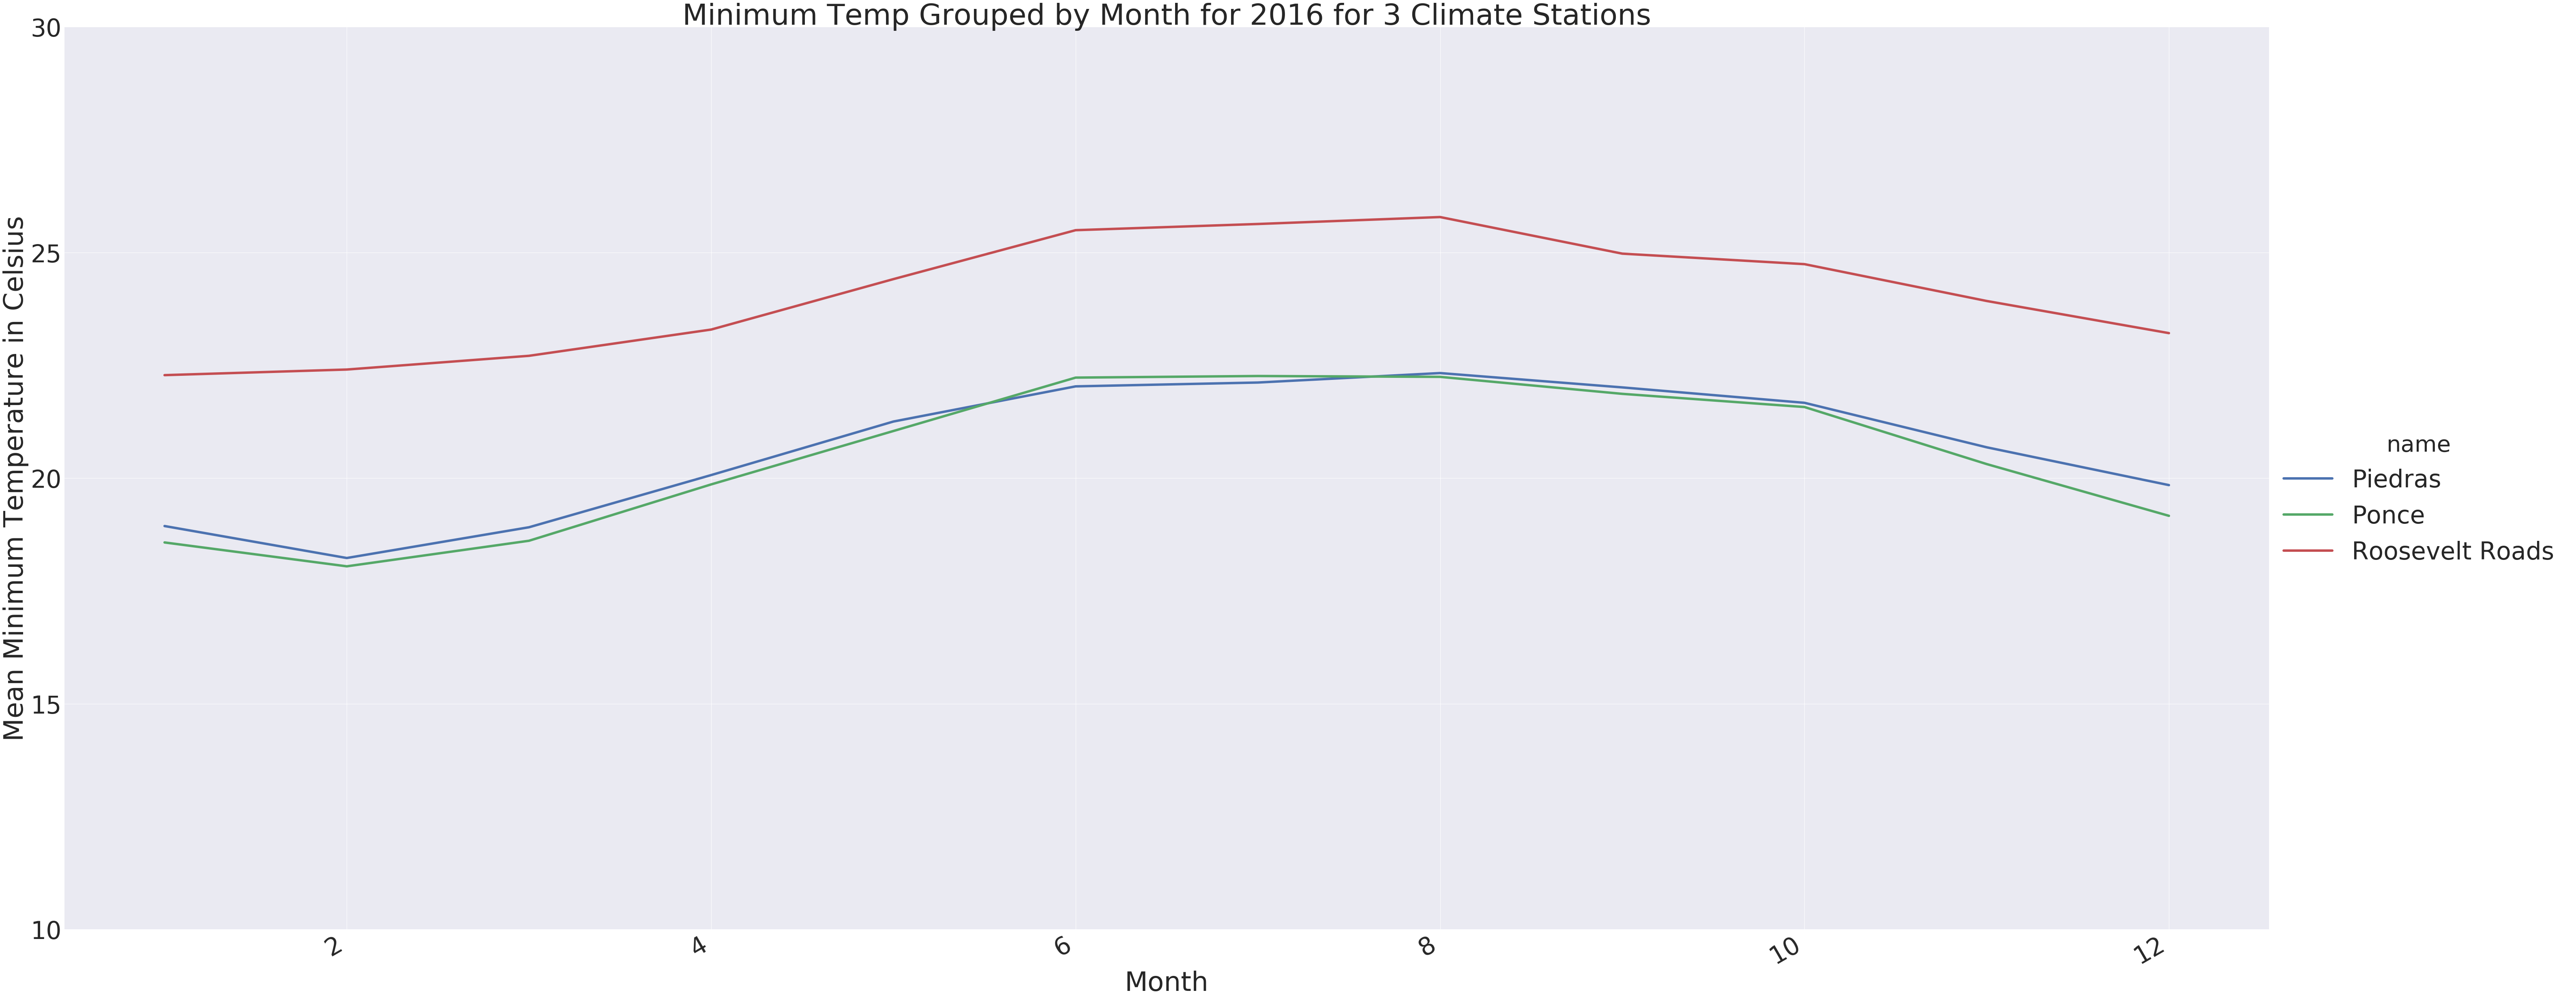

In [27]:
plotgroupsmonths(tmin_monthname_mean, yticksdaystmin, ytext='Mean Minimum Temperature in Celsius', titletext='Minimum Temp Grouped by Month for 2016 for 3 Climate Stations')

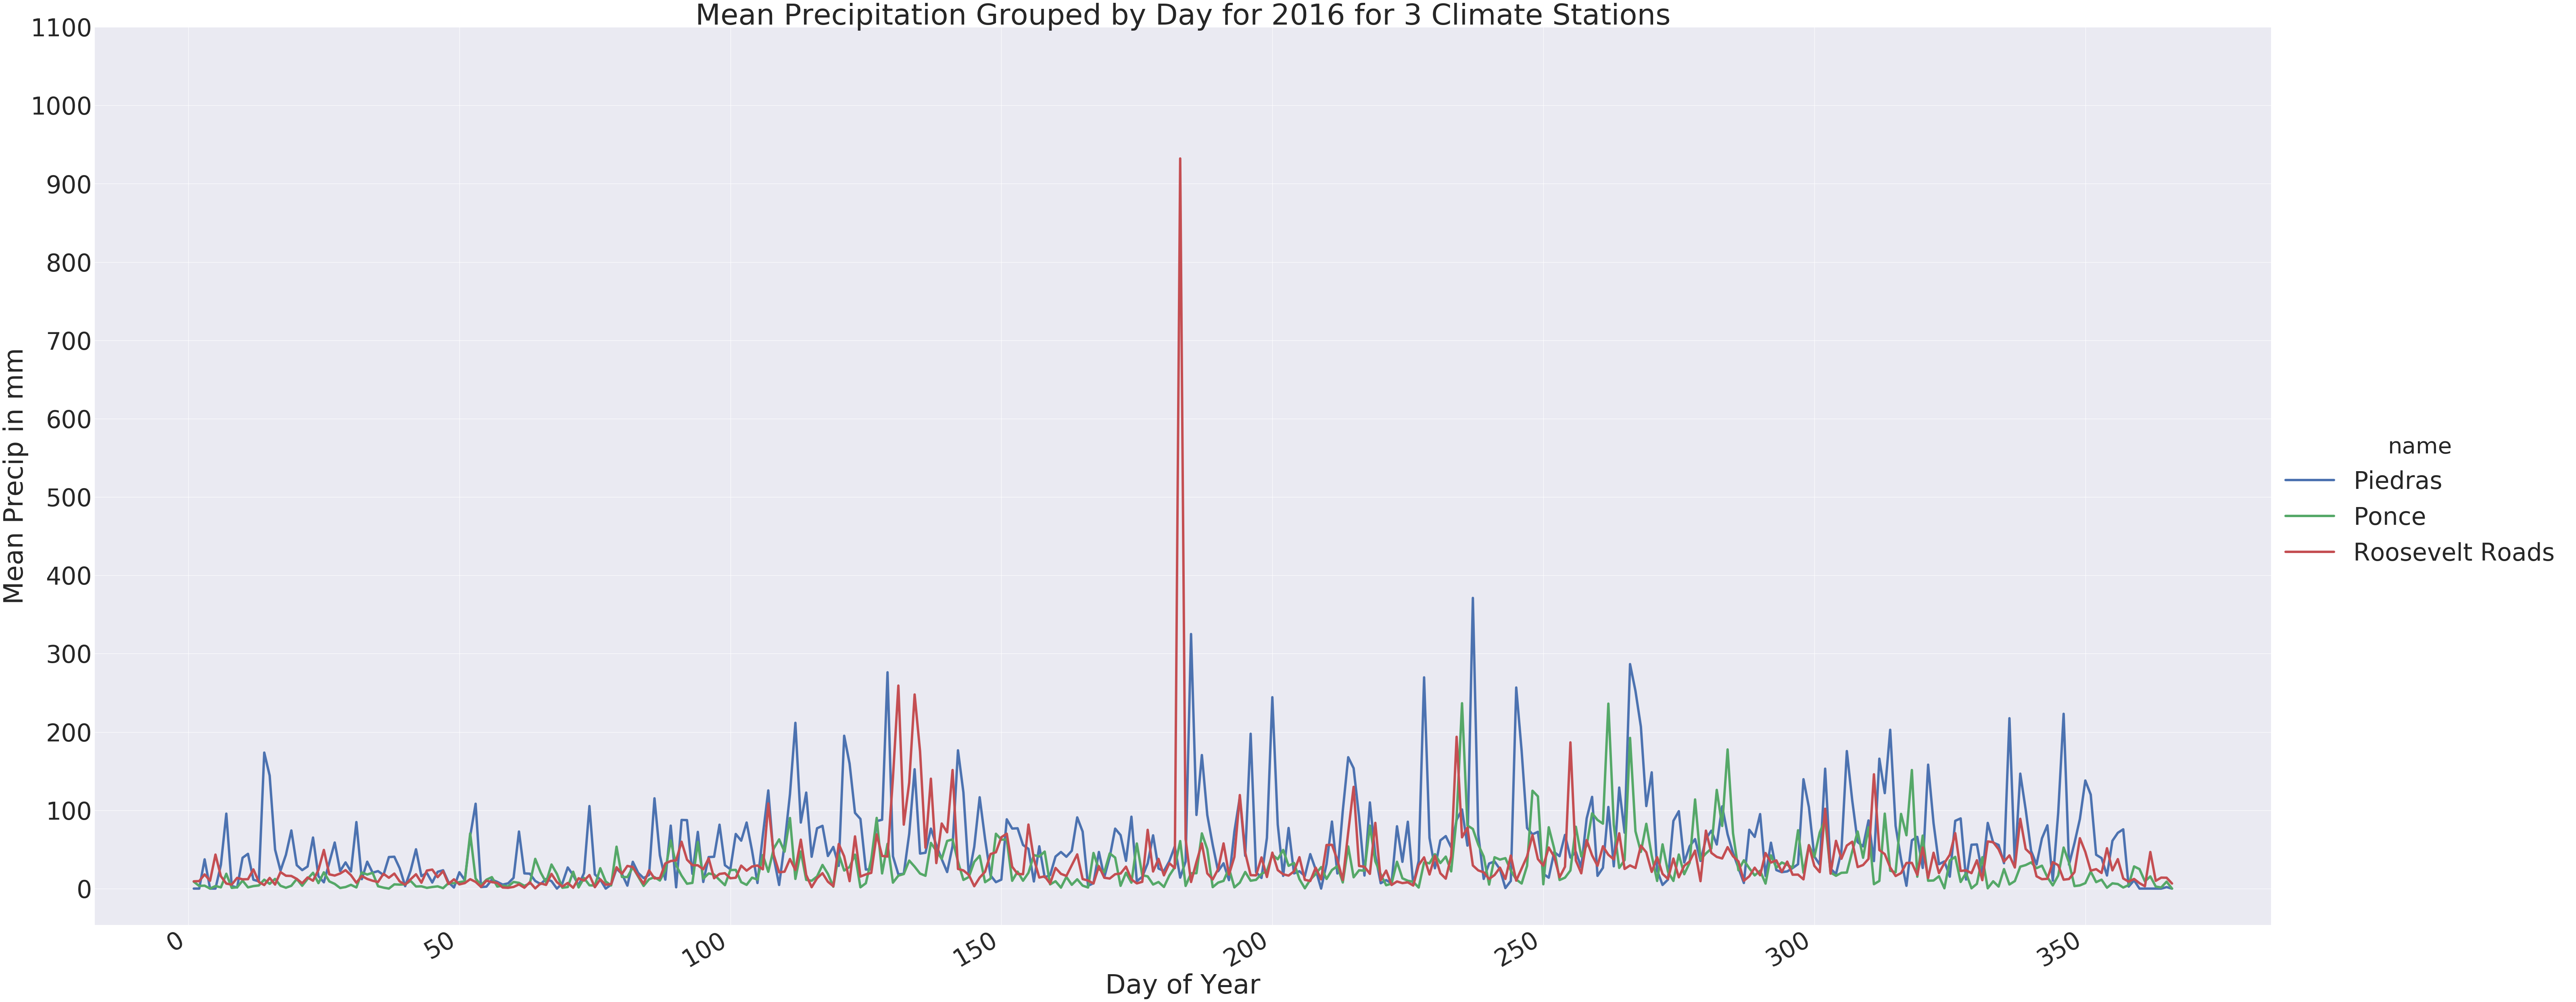

In [29]:
yticksdaysprecip = list(range(0,1101,100))
plotgroupsdays(precip_dayname_mean, yticksdaysprecip, ytext='Mean Precip in mm',titletext='Mean Precipitation Grouped by Day for 2016 for 3 Climate Stations')

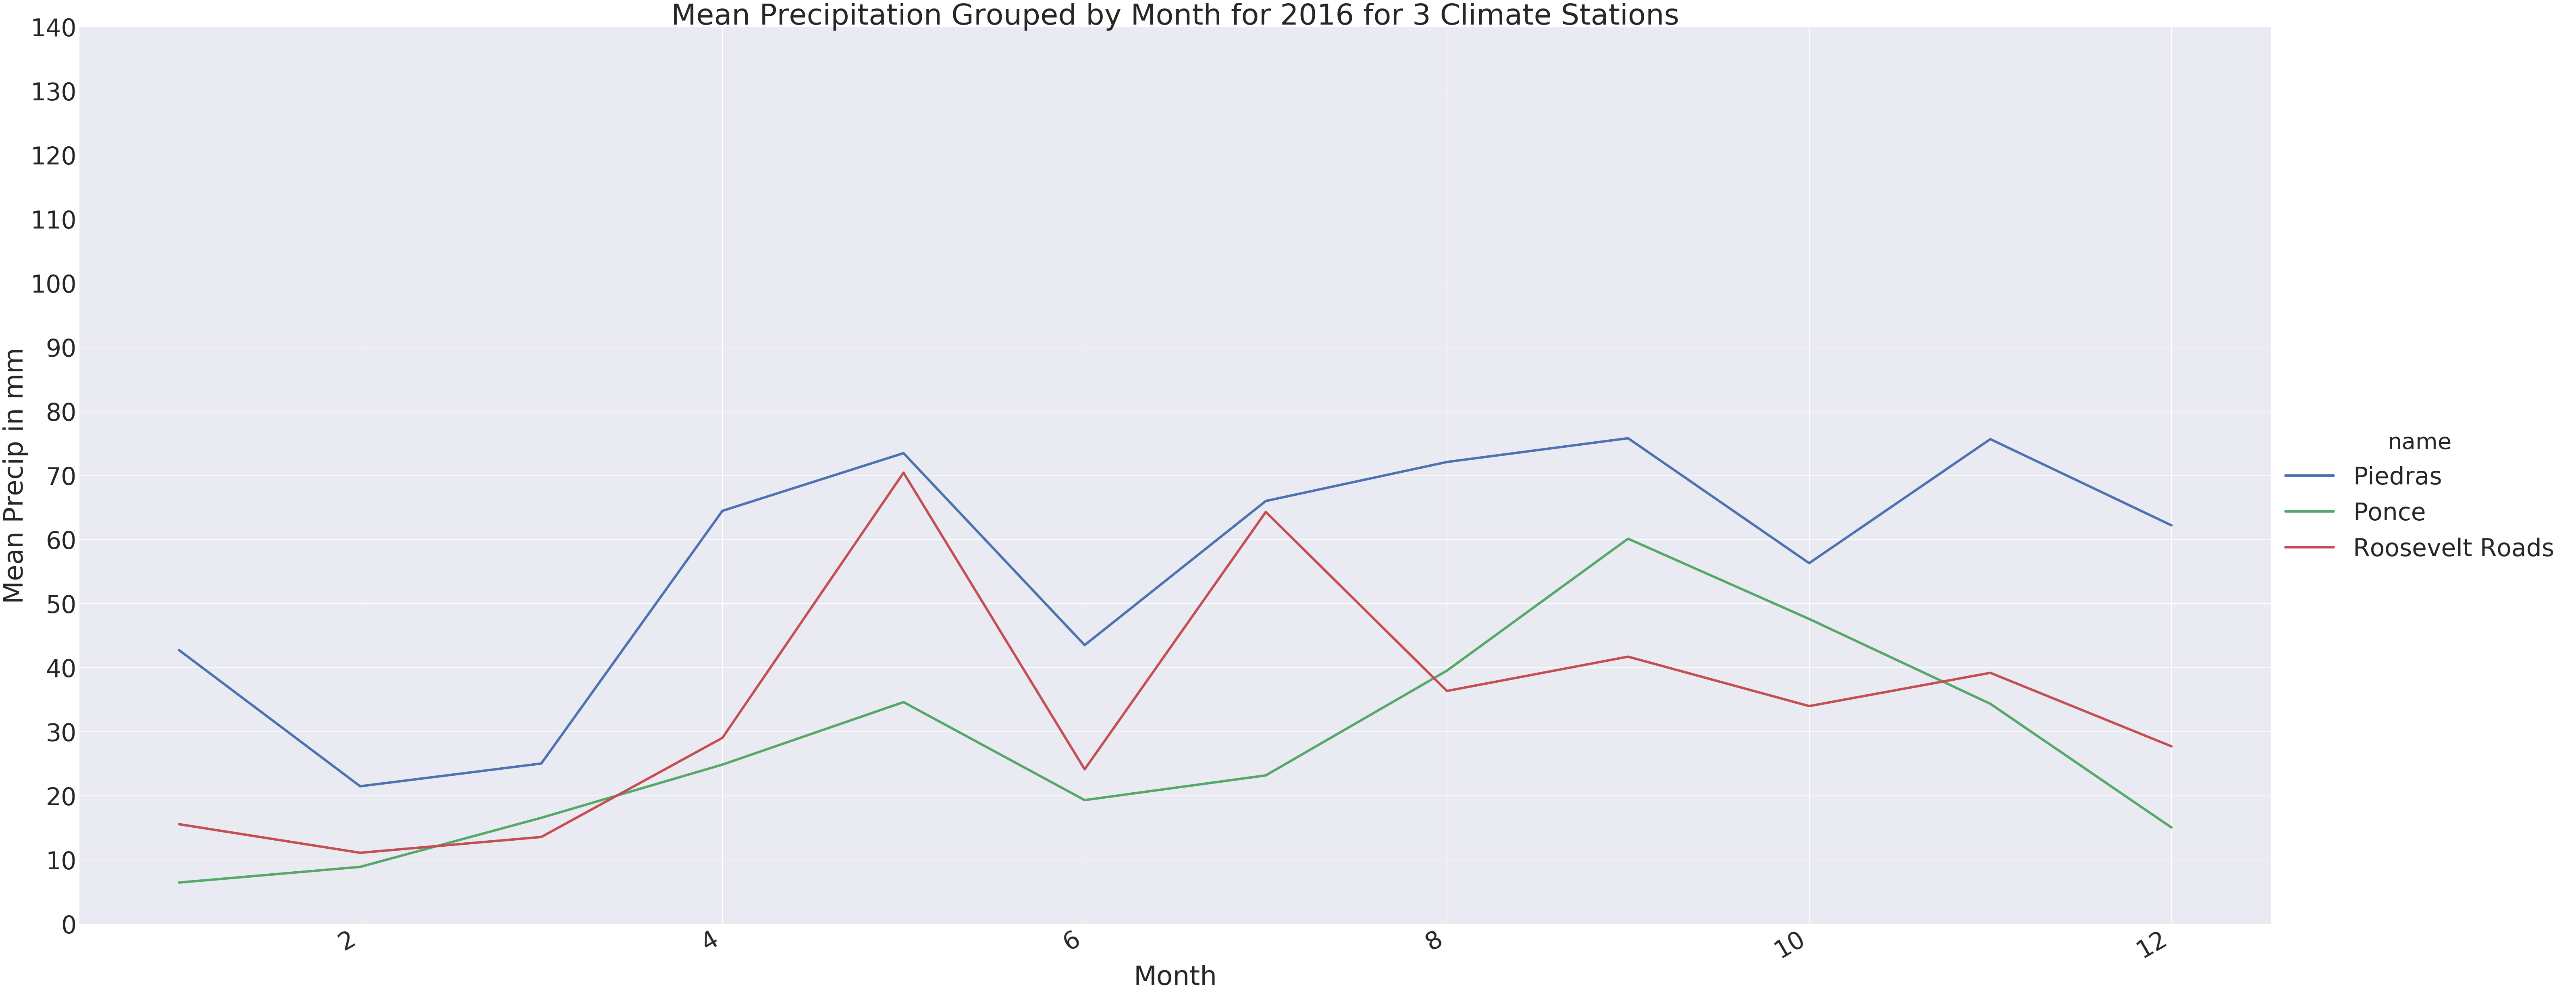

In [30]:
yticksmonthsprecip = list(range(0,141,10))
plotgroupsmonths(precip_monthname_mean, yticksmonthsprecip, ytext='Mean Precip in mm',titletext='Mean Precipitation Grouped by Month for 2016 for 3 Climate Stations')

## 2c) Calculate Annual Mean/Median Values 

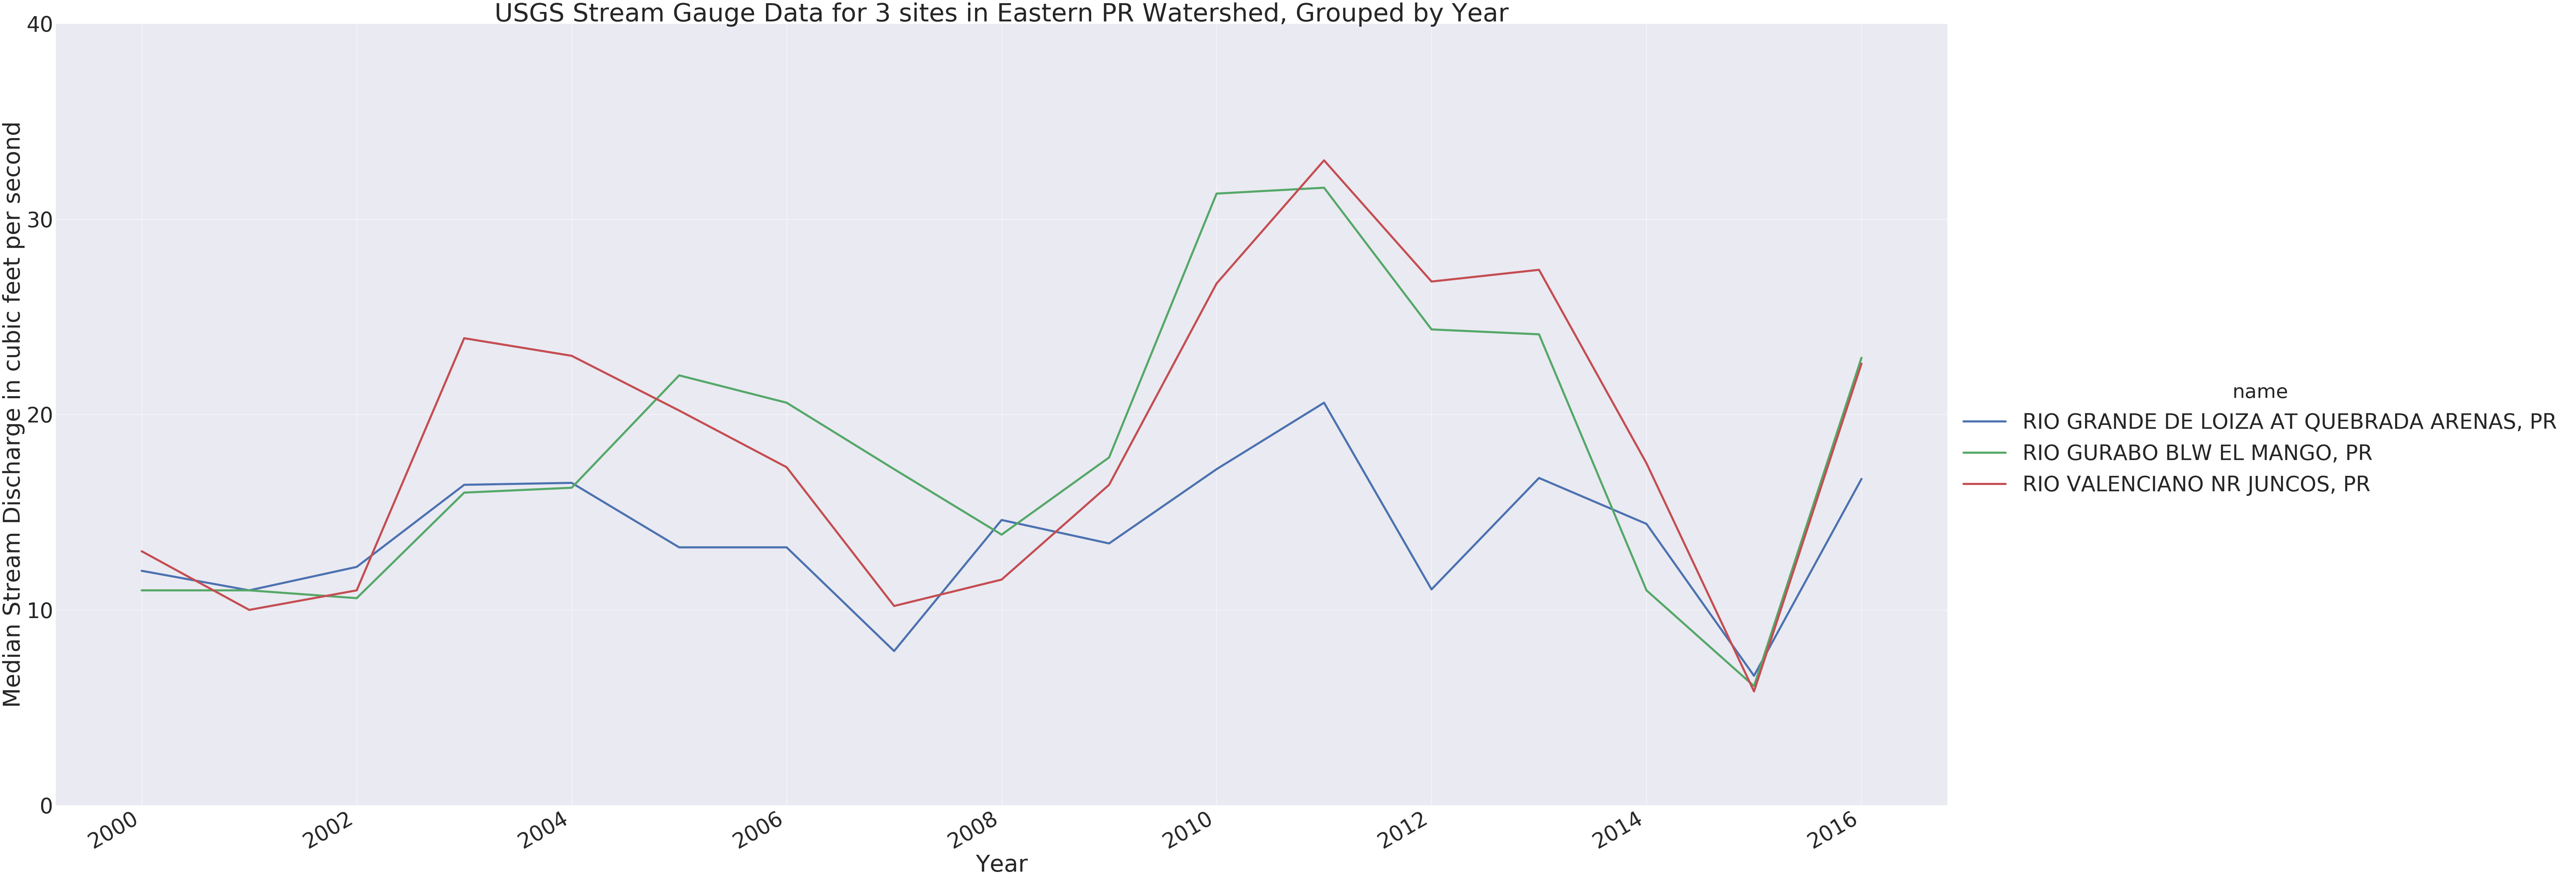

In [33]:
yticksflowyear = list(range(0, 41, 10))
plotgroupsyears(flow_yearname_med, yticksflowyear)

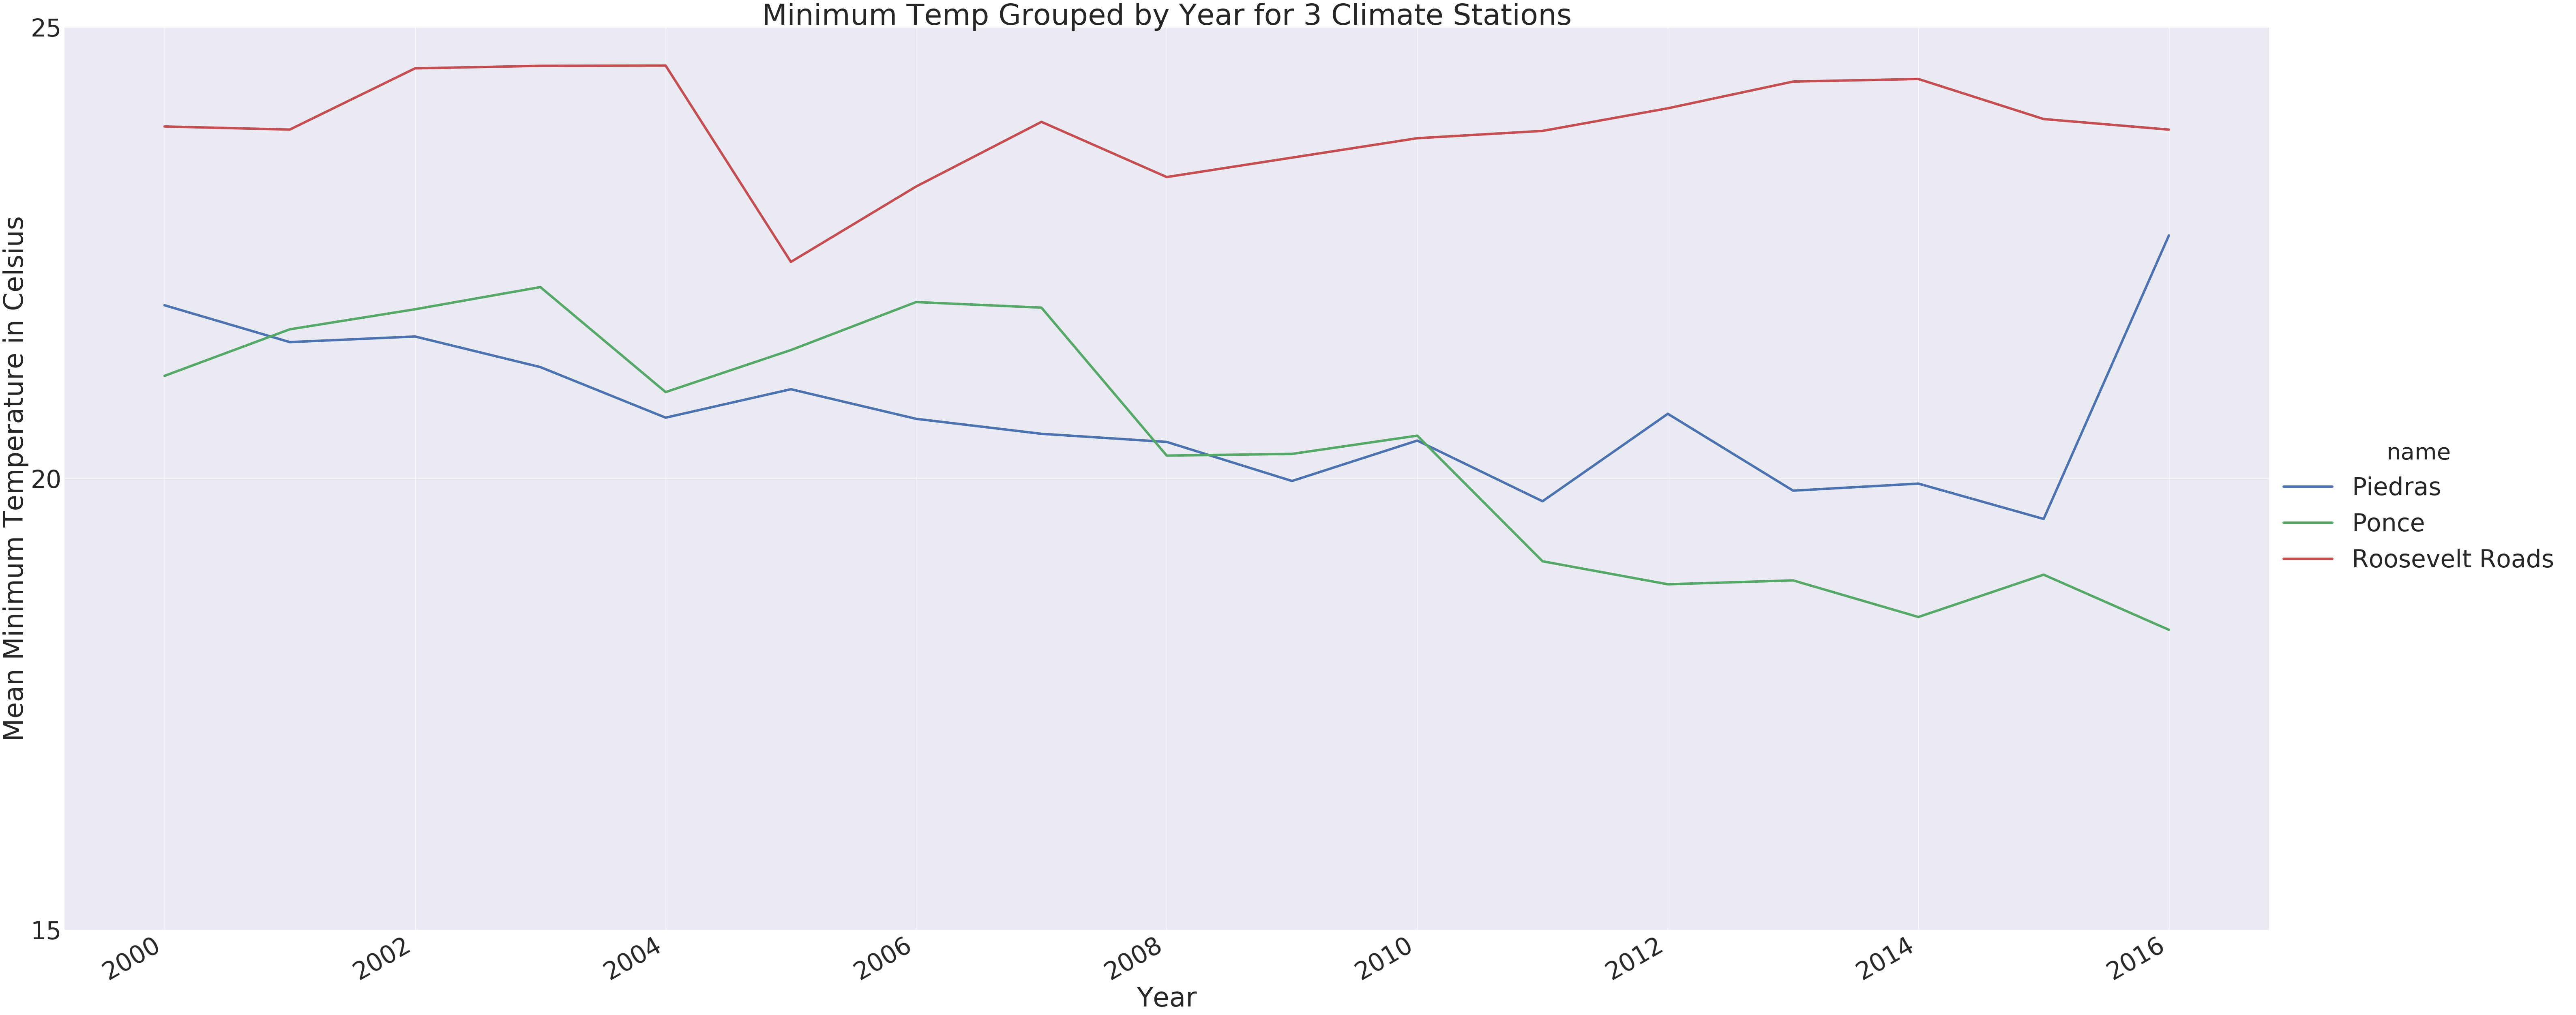

In [38]:
ytickstminyear = list(range(15,30,5))
plotgroupsyears(tmin_yearname_mean, ytickstminyear, ytext='Mean Minimum Temperature in Celsius', titletext='Minimum Temp Grouped by Year for 3 Climate Stations')

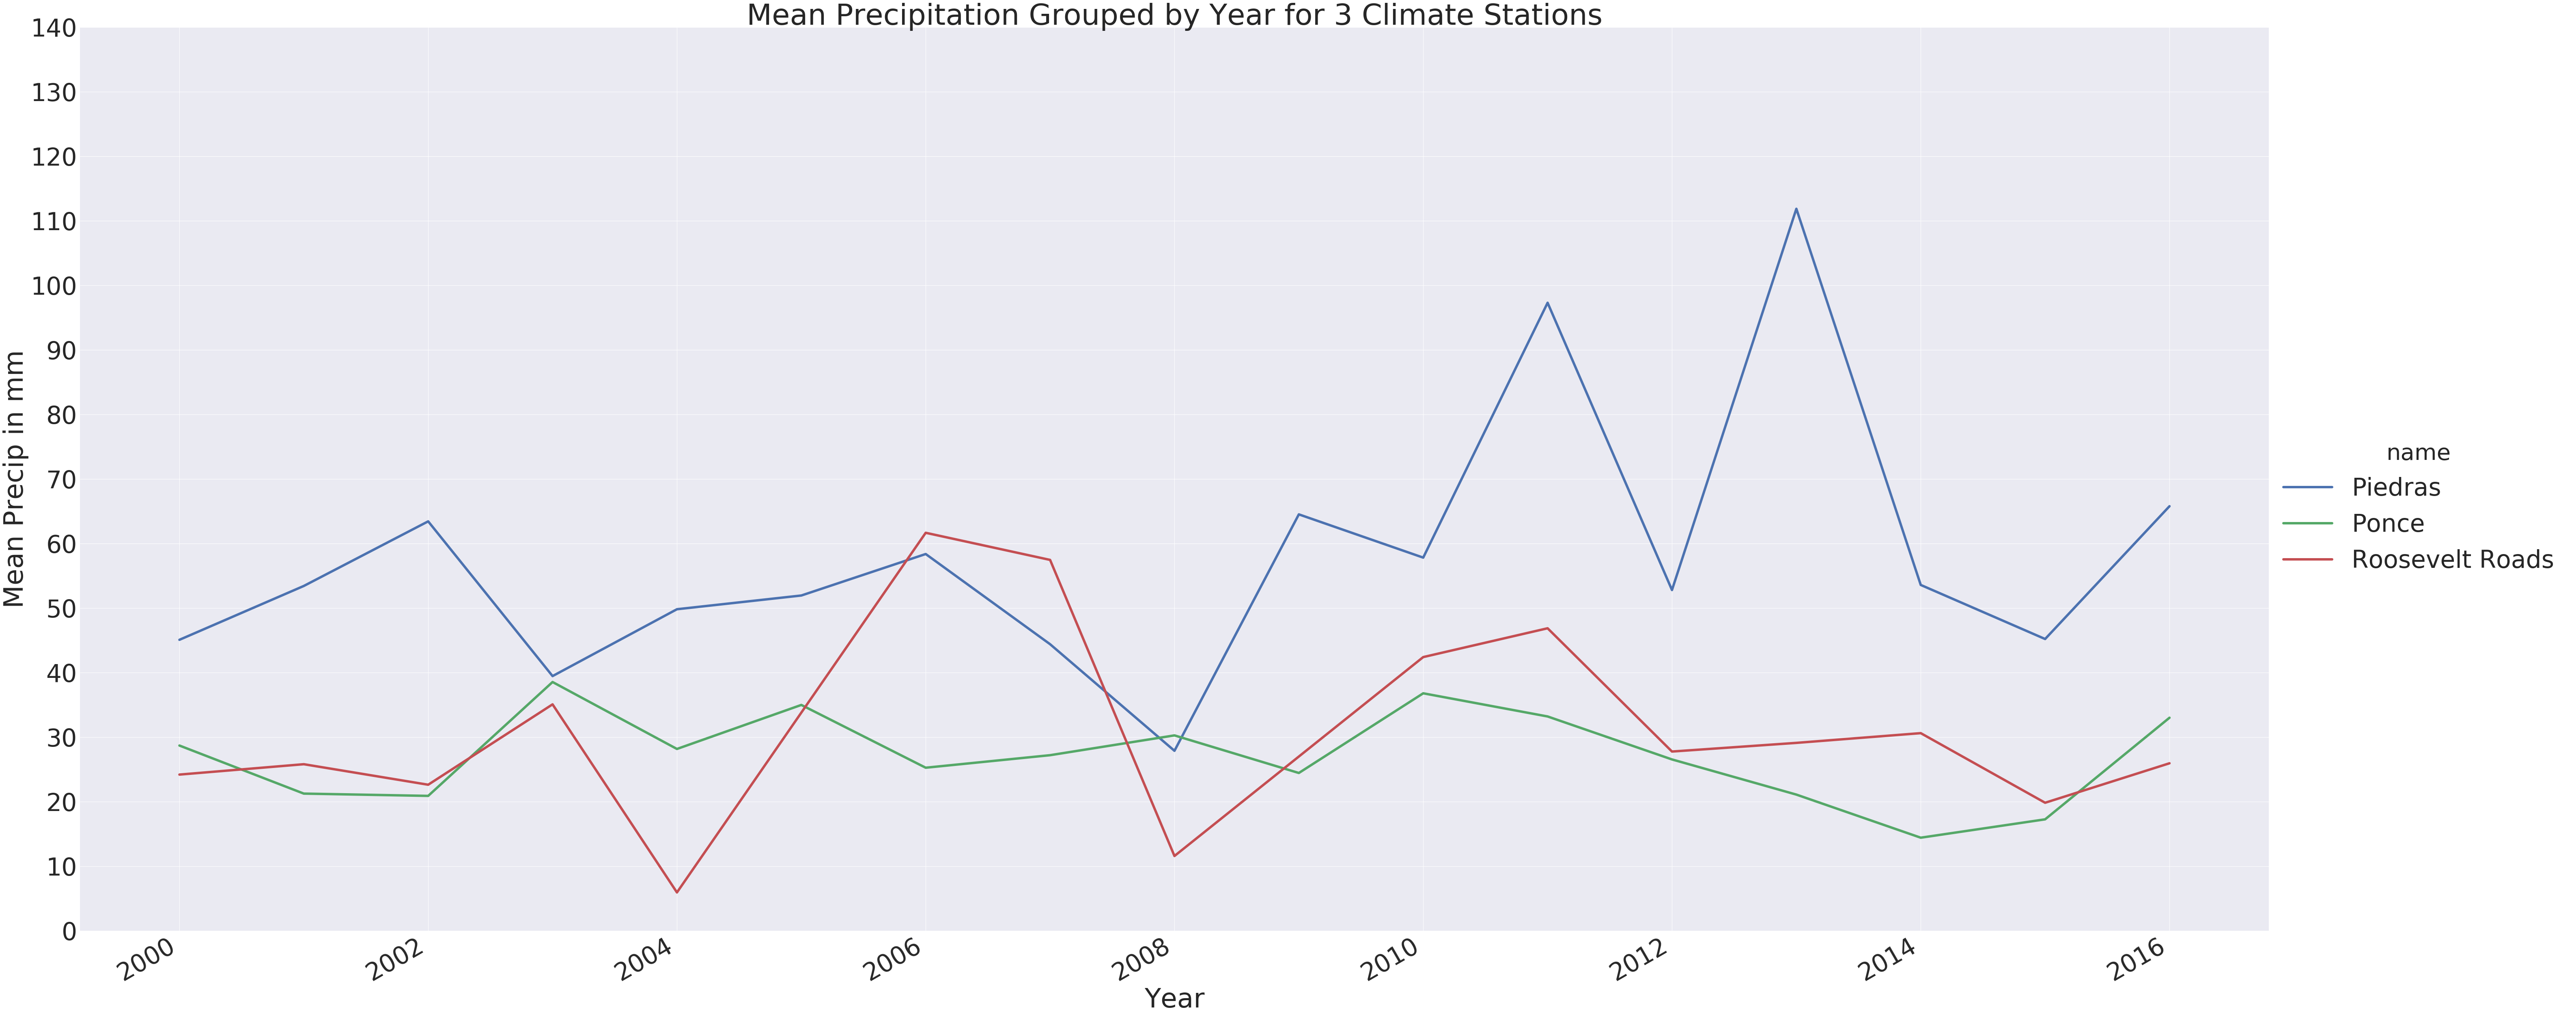

In [40]:
yticksprecipyear = list(range(0,141,10))
plotgroupsyears(precip_yearname_mean, yticksprecipyear,ytext='Mean Precip in mm',titletext='Mean Precipitation Grouped by Year for 3 Climate Stations')

## Calculate Seasonal Mean/Median

In [13]:
flowdf['quarter'] = [month%4+1 for month in flowdf['month']]
tmindf['quarter'] = [month%4+1 for month in tmindf['month']]
precipdf['quarter'] = [month%4+1 for month in precipdf['month']]

In [14]:
flow_seasons = flowdf.groupby(['year', 'quarter', 'name']).median()
tmin_seasons = tmindf.groupby(['year', 'quarter', 'name']).mean()
precip_seasons = precipdf.groupby(['year', 'quarter', 'name']).mean()
flow_seasons = flow_seasons.reset_index()
tmin_seasons = tmin_seasons.reset_index()
precip_seasons = precip_seasons.reset_index()

    
def plotgroupsseasons(df, ticklist, timestep='year', ytext='Median Stream Discharge in cubic feet per second', titletext='Data for 1 site in Eastern PR Watershed, Grouped by Year'):
    sn.set(font_scale=6, rc={"lines.linewidth": 6})
    f = sn.FacetGrid(df.reset_index(), hue='quarter', size=40, aspect=2)
    f.map(plt.plot, timestep, 'value').add_legend()
    f.ax.set(xlabel='Year',
            ylabel=ytext,
            title=titletext)
    f.fig.autofmt_xdate()
    f.set(yticks=ticklist)
    plt.show()

In [69]:
flow_seasons_subset.name.unique()

array(['RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR',
       'RIO GURABO BLW EL MANGO, PR', 'RIO VALENCIANO NR JUNCOS, PR'], dtype=object)

In [70]:
flow_seasons_subset = flow_seasons[flow_seasons.quarter != 2]
flow_seasons_subset = flow_seasons_subset[flow_seasons_subset.quarter != 4]
flow_seasons_subset = flow_seasons_subset[flow_seasons_subset.name != 'RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR']
flow_seasons_subset = flow_seasons_subset[flow_seasons_subset.name != 'RIO VALENCIANO NR JUNCOS, PR']

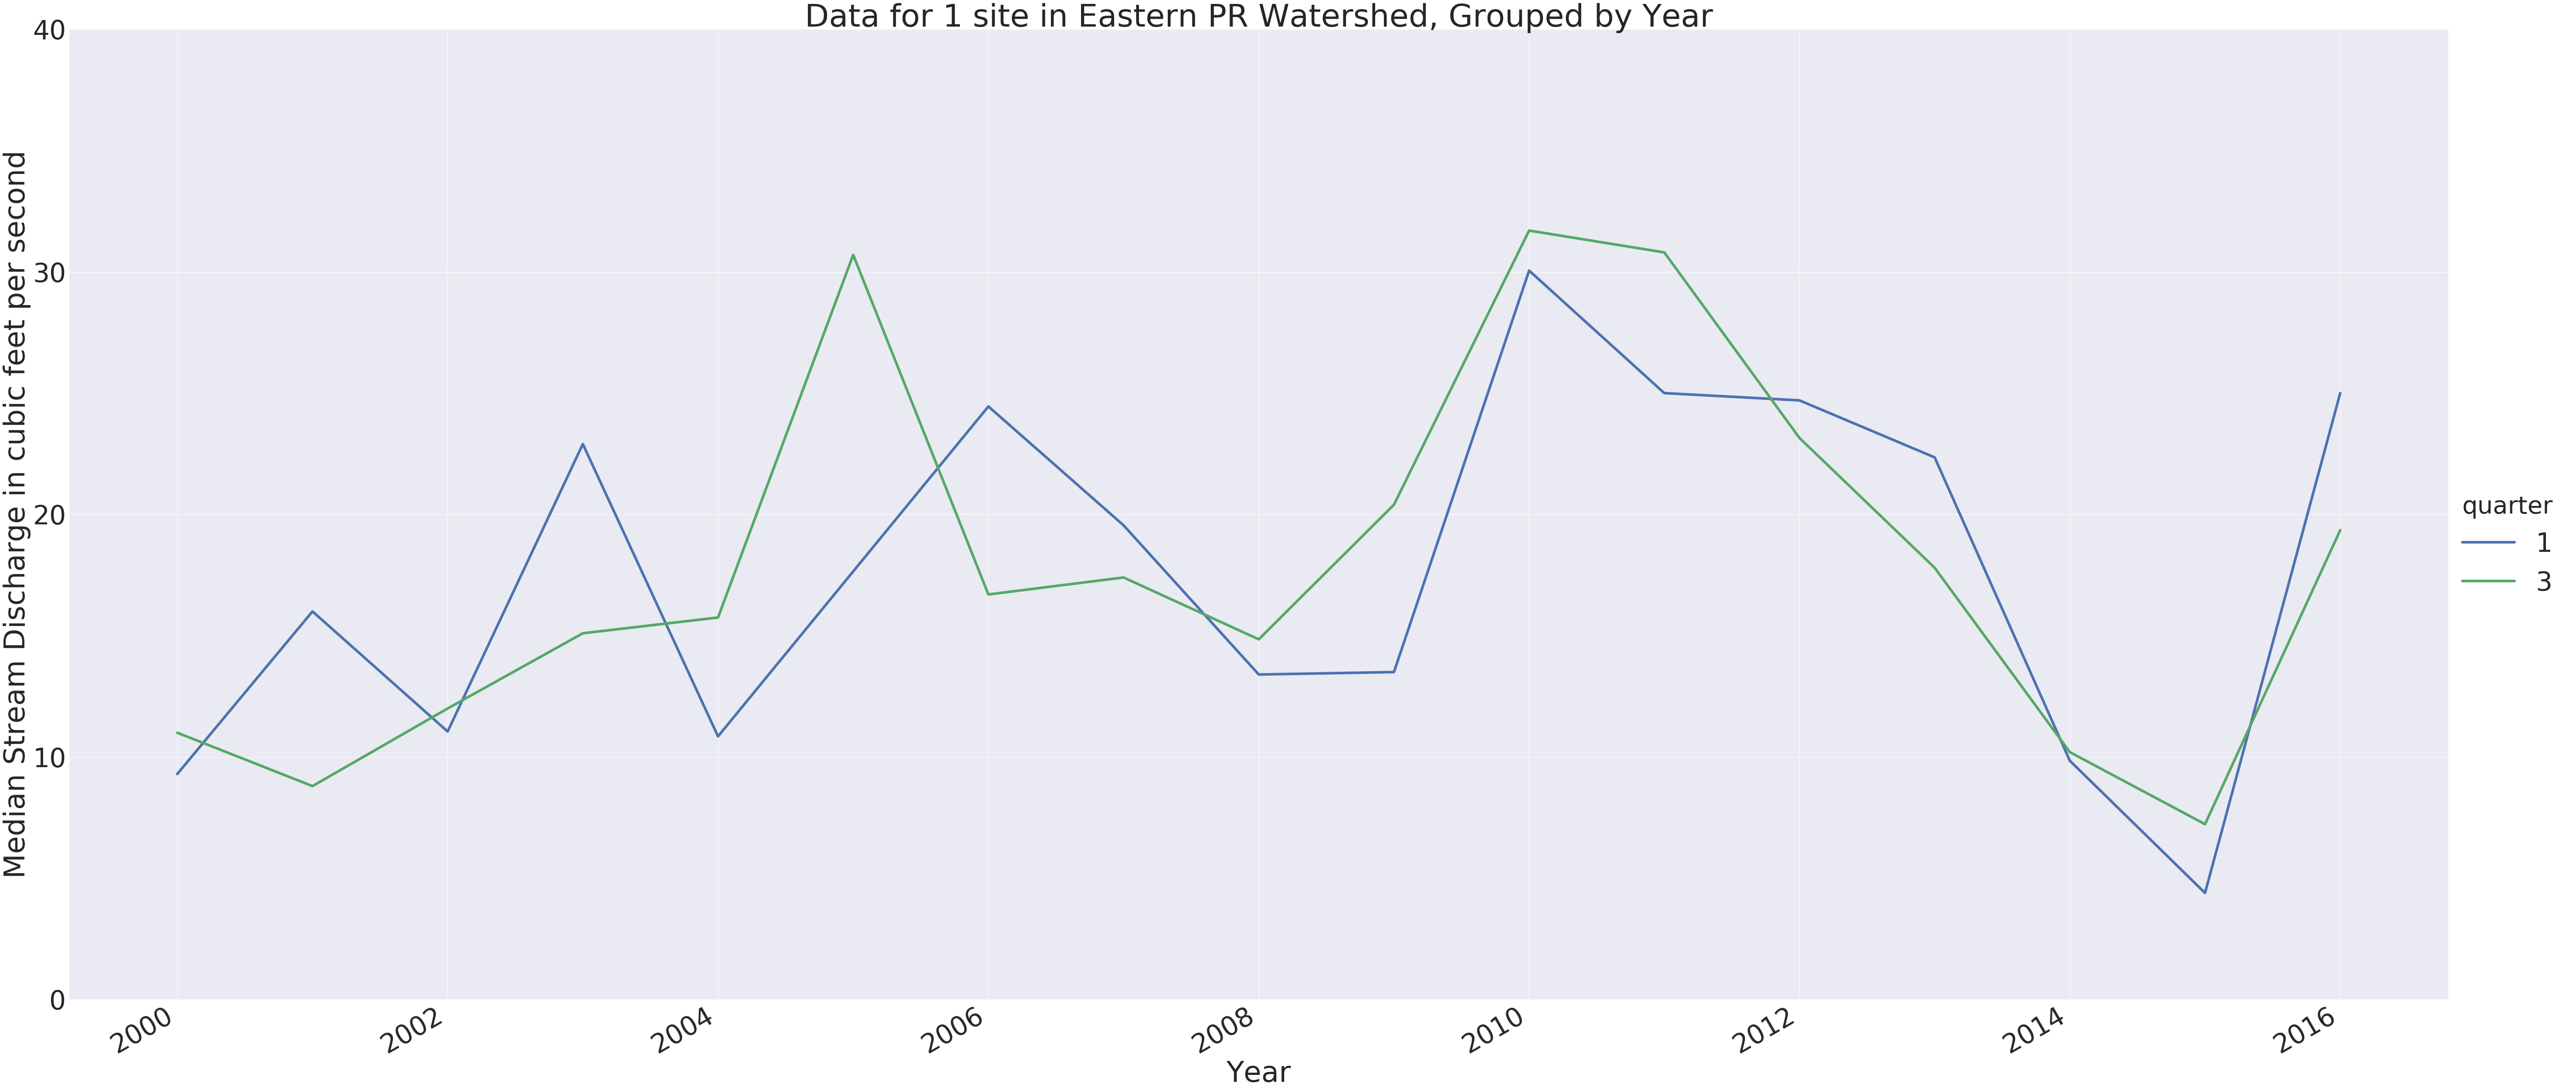

In [88]:
yticksseasonsflow = list(range(0,50,10))
plotgroupsseasons(flow_seasons_subset, yticksseasonsflow)

In [77]:
tmin_seasons.name.unique()

array(['Piedras', 'Ponce', 'Roosevelt Roads'], dtype=object)

In [15]:
def subset_stations(df):
    seasons_subset = df[df.quarter != 2]
    seasons_subset = seasons_subset[seasons_subset.quarter != 4]
    seasons_subset = seasons_subset[seasons_subset.name != 'Ponce']
    seasons_subset = seasons_subset[seasons_subset.name != 'Roosevelt Roads']
    return seasons_subset
tmin_seasons_subset = subset_stations(tmin_seasons)
precip_seasons_subset = subset_stations(precip_seasons)

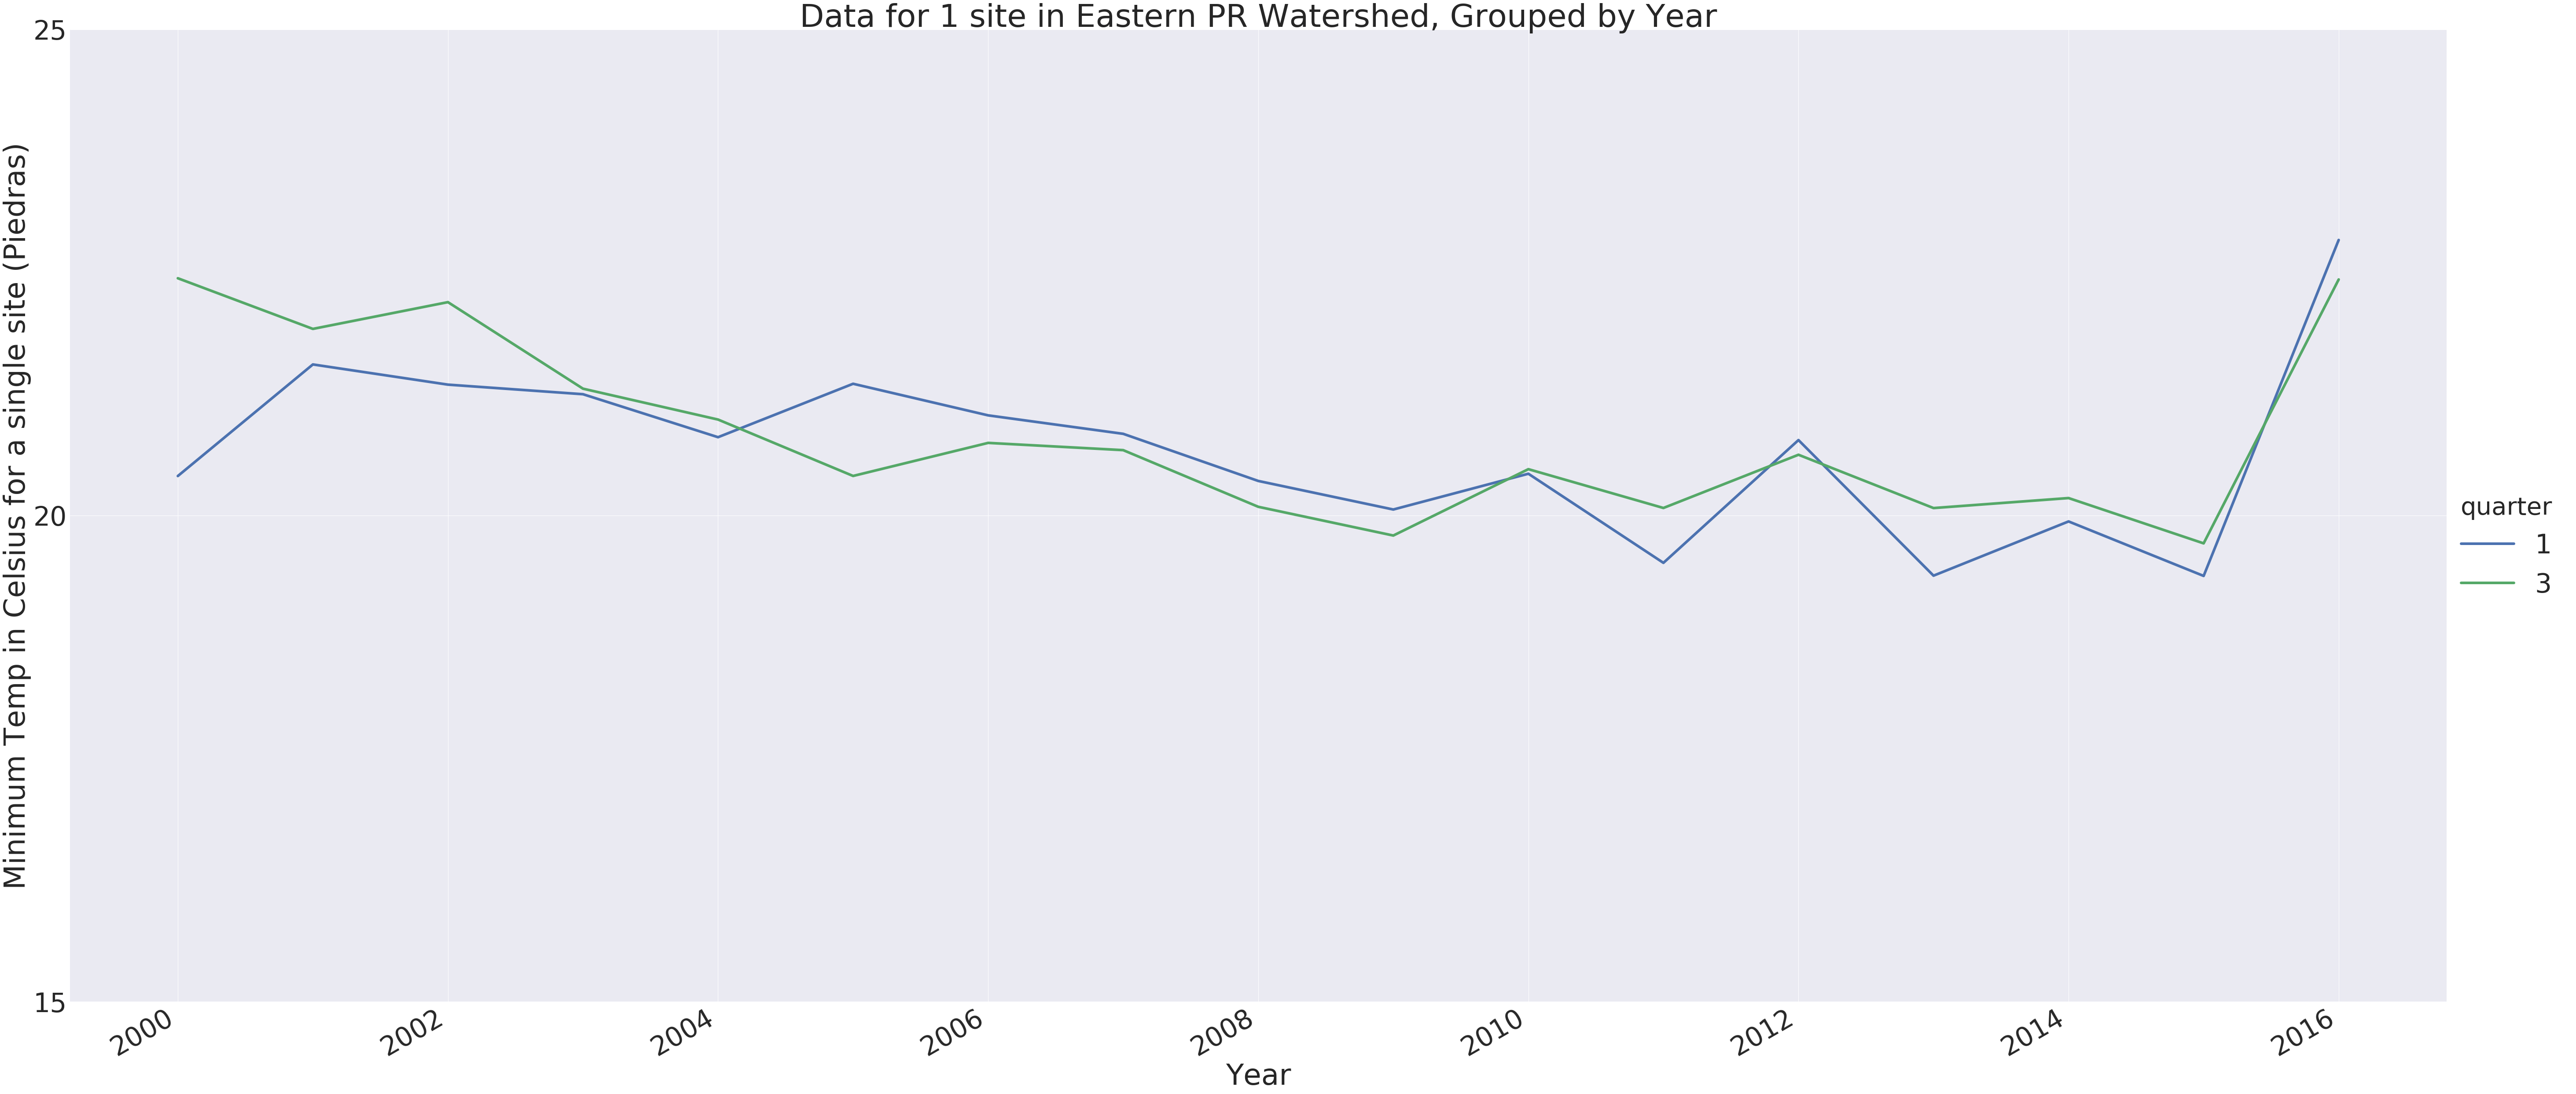

In [89]:
plotgroupsseasons(tmin_seasons_subset, ytickstminyear, ytext='Minimum Temp in Celsius for a single site (Piedras)')

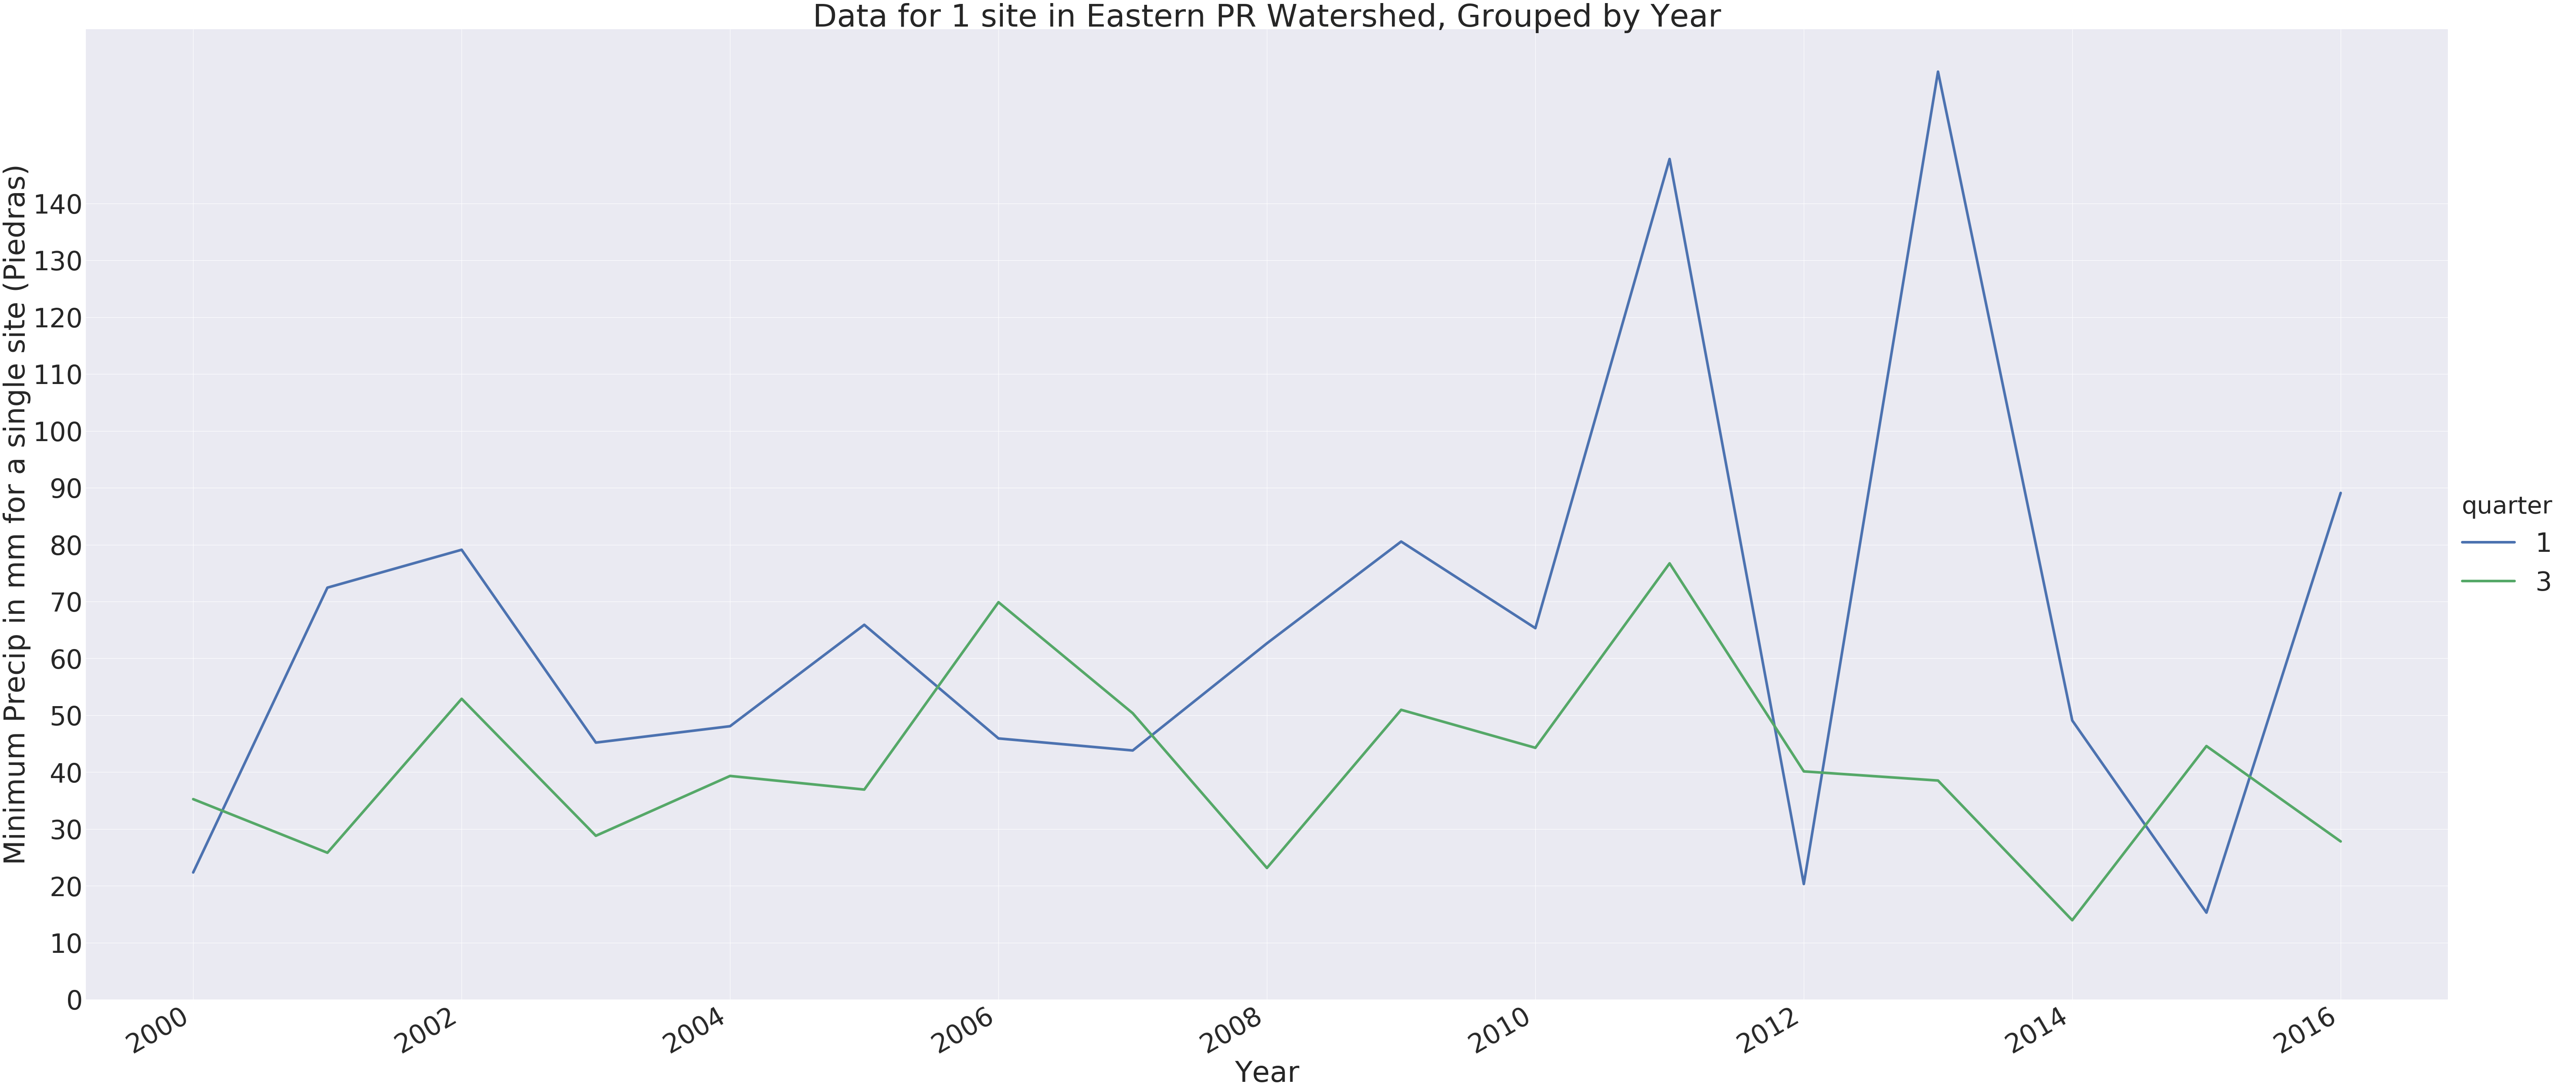

In [90]:
plotgroupsseasons(precip_seasons_subset, yticksprecipyear, ytext='Minimum Precip in mm for a single site (Piedras)')

## 2e Reflection

Because Puerto Rico is in a tropical climate, it has a relative lack of seasons. Temperature does not varry much between JFM and JJA and the same goes for stream flow. There is quite a large amount of variation in stream flow throught the years for both seasons. Precipitation on the other hand does show some variation between seasons, and we see that there was consistently more precip in JFM than JJA. It's interesting that the second lowest year in terms of precip occurred between the two highest years of prcip for JFM. I wonder if this was caused by any significant storm events, as our group by day plot above shows that a particular day between Day 1 and Day 25 exhibited double the precip of days surrounding it averaged over 16 years. The seasonal plot and the day plot indicate that some large storm events in JFM 2011 or 2013 may have influenced that gauge reading.

## 3a Fitting a Trend

In [27]:
flow_yearname_med

value  month    day
year name                                                            
2000 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  12.000    7.0  183.5
     RIO GURABO BLW EL MANGO, PR                 11.000    7.0  183.5
     RIO VALENCIANO NR JUNCOS, PR                13.000    7.0  183.5
2001 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  11.000    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 11.000    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                10.000    7.0  183.0
2002 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  12.200    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 10.600    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                11.000    7.0  183.0
2003 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  16.400    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 16.000    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                23.900    7.0  183.0
2004 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  16.500    7.0  183.5
     RIO GURABO BLW EL MANGO, PR                 16.250    7.0  183.5
     RIO VALENCIANO NR JUNCOS, PR                23.000    7.0  183.5
2005 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  13.200    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 22.000    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                20.200    7.0  183.0
2006 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  13.200    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 20.600    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                17.300    7.0  183.0
2007 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR   7.895    5.0  136.5
     RIO GURABO BLW EL MANGO, PR                 17.200    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                10.200    7.0  183.0
2008 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  14.600   11.0  320.0
     RIO GURABO BLW EL MANGO, PR                 13.850    7.0  183.5
     RIO VALENCIANO NR JUNCOS, PR                11.550    7.0  183.5
2009 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  13.400    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 17.800    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                16.400    7.0  183.0
2010 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  17.200    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 31.300    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                26.700    7.0  183.0
2011 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  20.600    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 31.600    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                33.000    7.0  183.0
2012 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  11.050    7.0  183.5
     RIO GURABO BLW EL MANGO, PR                 24.350    7.0  183.5
     RIO VALENCIANO NR JUNCOS, PR                26.800    7.0  183.5
2013 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  16.750    7.0  183.5
     RIO GURABO BLW EL MANGO, PR                 24.100    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                27.400    7.0  183.0
2014 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  14.400    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 11.000    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                17.500    7.0  183.0
2015 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR   6.630    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                  6.100    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                 5.830    7.0  183.0
2016 RIO GRANDE DE LOIZA AT QUEBRADA ARENAS, PR  16.700    7.0  183.0
     RIO GURABO BLW EL MANGO, PR                 22.900    7.0  183.0
     RIO VALENCIANO NR JUNCOS, PR                22.600    7.0  183.0

In [31]:
import statsmodels.formula.api as smf
valenciano_flow_med = flow_yearname_med.reset_index()[flow_yearname_med.reset_index().name == 'RIO GURABO BLW EL MANGO, PR']
xi = valenciano_flow_med.year
y = valenciano_flow_med.value
y = [int(val) for val in y]
model = smf.OLS(y,xi).fit()
model.summary()

/home/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     103.2
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.20e-08
Time:                        15:35:14   Log-Likelihood:                -57.191
No. Observations:                  17   AIC:                             116.4
Df Residuals:                      16   BIC:                             117.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0088      0.001     10.161      0.000       0.007       0.011
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.698
Skew:                           0.361   Prob(JB):                        0.705
Kurtosis:                       2.319   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
xi = tmin_seasons_subset.year[tmin_seasons_subset.quarter == 1]
y = tmin_seasons_subset.value[tmin_seasons_subset.quarter == 1]
y = [int(val) for val in y]
model = smf.OLS(y,xi).fit()
model.summary()

/home/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8468.
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           3.14e-23
Time:                        15:57:40   Log-Likelihood:                -21.890
No. Observations:                  17   AIC:                             45.78
Df Residuals:                      16   BIC:                             46.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0100      0.000     92.024      0.000       0.010       0.010
==============================================================================
Omnibus:                        0.556   Durbin-Watson:                   1.221
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.584
Skew:                           0.098   Prob(JB):                        0.747
Kurtosis:                       2.113   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
xi = precip_seasons_subset.year[precip_seasons_subset.quarter == 1]
y = precip_seasons_subset.value[precip_seasons_subset.quarter == 1]
y = [int(val) for val in y]
model = smf.OLS(y,xi).fit()
model.summary()

/home/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     45.36
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           4.79e-06
Time:                        15:58:00   Log-Likelihood:                -86.296
No. Observations:                  17   AIC:                             174.6
Df Residuals:                      16   BIC:                             175.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0325      0.005      6.735      0.000       0.022       0.043
==============================================================================
Omnibus:                        7.340   Durbin-Watson:                   2.672
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                4.467
Skew:                           1.168   Prob(JB):                        0.107
Kurtosis:                       3.923   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Comments on Regression

The fit for the temperature data was the best since the temperature data has the least variance, as noted in 2e. The linear model for this data has an R-squared of .998. It also passes a left and right sided significance test (with alpha = .01). All regression tests pass with an alpha = .1.